In [1]:
import tensorflow as tf
import pandas as pd
import sklearn as sk
import pylast
from dotenv import load_dotenv
import os
import urllib3
from urllib.parse import quote
import ssl
import certifi
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.poolmanager import PoolManager
import logging
import os
import warnings

2024-08-31 17:18:15.090981: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Disable SSL warnings
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Configure logging
logging.basicConfig(level=logging.INFO, filename='data_generation.log', filemode='a',
                    format='%(asctime)s - %(levelname)s - %(message)s')

# Disables INFO messages from being printed out
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'  # 0 = all messages are logged (default behavior)
                                        # 1 = INFO messages are not printed
                                        # 2 = INFO and WARNING messages are not printed
                                        # 3 = INFO, WARNING, and ERROR messages are not printed

warnings.filterwarnings('ignore', category=UserWarning, module='tensorflow')

In [3]:
def configure_lastfm_api():
    """Configure Last.fm API using environment variables."""
    load_dotenv()

    LASTFM_API_KEY = os.getenv('LASTFM_API_KEY')
    LASTFM_API_SECRET = os.getenv('LASTFM_API_SECRET')

    if not LASTFM_API_KEY or not LASTFM_API_SECRET:
        raise ValueError("API key and secret must be set in the .env file")

    return LASTFM_API_KEY, LASTFM_API_SECRET

In [4]:
def test_api_connection(api_key):
    """Test API connection by making a direct request to the Last.fm API."""
    try:
        url = f"https://ws.audioscrobbler.com/2.0/?method=chart.gettoptracks&api_key={api_key}&format=json"
        response = requests.get(url, verify=False)
        response.raise_for_status()
        data = response.json()
        for track in data['tracks']['track'][:1]:  # Fetch only one track for testing
            print(f"Track: {track['name']} by {track['artist']['name']}")
    except Exception as e:
        print(f"An error occurred: {e}")

In [5]:
if __name__ == '__main__':
    try:
        api_key, _ = configure_lastfm_api()
        test_api_connection(api_key)
    except Exception as e:
        print(f"Configuration error: {e}")

Track: Good Luck, Babe! by Chappell Roan


In [7]:
def fetch_track_details(api_key, track_name, artist_name):
    """Fetch genre (tags) and similar tracks for a given track."""
    encoded_artist_name = quote(artist_name)
    encoded_track_name = quote(track_name)
    tags_url = f"https://ws.audioscrobbler.com/2.0/?method=track.gettoptags&api_key={api_key}&artist={encoded_artist_name}&track={encoded_track_name}&format=json"
    similar_url = f"https://ws.audioscrobbler.com/2.0/?method=track.getsimilar&api_key={api_key}&artist={encoded_artist_name}&track={encoded_track_name}&format=json"

    try:
        tags_response = requests.get(tags_url, verify=False)
        tags_response.raise_for_status()
        tags_data = tags_response.json()

        similar_response = requests.get(similar_url, verify=False)
        similar_response.raise_for_status()
        similar_data = similar_response.json()

        tags = [tag['name'] for tag in tags_data['toptags']['tag']] if 'toptags' in tags_data and 'tag' in tags_data['toptags'] else []
        similar_tracks = [track['name'] for track in similar_data['similartracks']['track']] if 'similartracks' in similar_data and 'track' in similar_data['similartracks'] else []

        return tags, similar_tracks
    except requests.exceptions.RequestException as e:
        logging.error(f"HTTP error while fetching details for track '{track_name}' by '{artist_name}': {e}")
        return [], []
    except ValueError as e:
        logging.error(f"Decoding error while fetching details for track '{track_name}' by '{artist_name}': {e}")
        return [], []

In [8]:
def fetch_lastfm_data(api_key, limit=200):
    """Fetch top tracks from Last.fm API and return as a DataFrame."""
    try:
        tracks = []
        page_limit = 100  # Number of tracks per page
        pages = limit // page_limit + (1 if limit % page_limit != 0 else 0)

        for page in range(1, pages + 1):
            url = f"https://ws.audioscrobbler.com/2.0/?method=chart.gettoptracks&api_key={api_key}&format=json&limit={page_limit}&page={page}"
            response = requests.get(url, verify=False)
            response.raise_for_status()
            data = response.json()
            tracks.extend(data['tracks']['track'])

        track_data = []
        for track in tracks[:limit]:
            name = track['name']
            artist = track['artist']['name']
            album = track['album']['title'] if 'album' in track else None
            playcount = track['playcount']
            tags, similar_tracks = fetch_track_details(api_key, name, artist)
            track_data.append({
                'name': name,
                'artist': artist,
                'album': album,
                'playcount': playcount,
                'tags': ', '.join(tags),
                'similar_tracks': ', '.join(similar_tracks)
            })
            logging.info(f"Fetched details for track '{name}' by '{artist}'")

        df = pd.DataFrame(track_data)
        return df

    except Exception as e:
        logging.error(f"An error occurred: {e}")
        return pd.DataFrame()

In [20]:
if __name__ == '__main__':
    try:
        api_key, _ = configure_lastfm_api()
        df = fetch_lastfm_data(api_key, limit=10000)  # Adjust the limit as needed
        if df is not None:
            print(df.head())  # Print the first few rows of the DataFrame to verify

            # Ensure the directory exists
            output_dir = os.path.join(os.getcwd(), '/Users/johnphillip/spotify_music_recommendation/data/raw')
            os.makedirs(output_dir, exist_ok=True)

            # Save DataFrame to the specified path
            output_path = os.path.join(output_dir, 'top_tracks.csv')
            df.to_csv(output_path, index=False)
            print(f"Data saved to {output_path}")
        else:
            print("Failed to fetch data, DataFrame is None")
    except Exception as e:
        logging.error(f"Configuration error: {e}")

                         name          artist album playcount  \
0             the boy is mine   Ariana Grande  None  11002687   
1  I like the way you kiss me         Artemas  None   7725469   
2                 Money Trees  Kendrick Lamar  None  21726085   
3                    Dark Red      Steve Lacy  None  24999120   
4                THE GREATEST   Billie Eilish  None   4874770   

                                                tags  \
0  rnb, 2024, pop, AOTY, best of 2024, female voc...   
1  coldwave, new wave, post-punk, synthpop, darkw...   
2  MySpotigramBot, rap, Hip-Hop, west coast hip h...   
3  indie pop, rnb, indie, pop, alternative, Neo S...   
4  epic, soul, alternative rock, emo, folk, power...   

                                      similar_tracks  
0  bye, don't wanna break up again, ALLIIGATOR TE...  
1  The Perfect Girl, Lovers From The Past, Hate.,...  
2  m.A.A.d city, Bitch, Don’t Kill My Vibe, Wesle...  
3  Bad Habit, Cigarettes out the Window, Telephon...

In [6]:
import requests

try:
    response = requests.get('https://www.google.com')
    print(f"Status Code: {response.status_code}")
except requests.exceptions.SSLError as e:
    print(f"SSL Error: {e}")
except Exception as e:
    print(f"An error occurred: {e}")


Status Code: 200


In [408]:
data_path = '/Users/johnphillip/spotify_music_recommendation/data/raw/top_tracks.csv'
raw_data = pd.read_csv(data_path)
raw_data.head()

,name,artist,album,playcount,tags,similar_tracks
0,the boy is mine,Ariana Grande,NaN,11002687,"rnb, 2024, pop, AOTY, best of 2024, female vocalists, pop-soul, new jack swing, doo-wop, trap, hip-hop soul, pop perfection, r n b, the very best, Cheater, Iconic, Homewrecker, Ariana Grande, song of the decade, soty, 90s inspired, 2020s, 2000s rnb, alexcore, pluggnb, MySpotigramBot, y2k inspired, this song is for biel, biel-loves-this-song, dead internet theory","bye, don't wanna break up again, ALLIIGATOR TEARS, Tyrant, OKLOSER, dIsreSPeCtfUl, scared of my guitar, So Long, London, Who’s Afraid of Little Old Me?, Love Language, On My Mama, FYS, Kiss It Better, i hate u, Boy Bye, Cardboard Box, Do It, West Coast, Ungodly Hour, Good in Goodbye, Yuck, Smoke (feat. Lucky Daye), Born to Die, Sex With Me, Say My Name, Wide Awake, The Night Is Still Young, Mrs. Potato Head, Underwater, Pity Party, Run Away with Me, Long Way 2 Go, Body, Sledgehammer, Wrecking Ball, Island, Can't Feel My Face, Honeymoon Fades, Bills, Bills, Bills, The Hills, X (feat. Jeremih), Bad Kind of Butterflies, The Heart Wants What It Wants, Perfect Crime, Get on Your Knees (feat. Ariana Grande), Good for You (feat. A$AP Rocky), Thumbs, Your Teeth in My Neck, Unconditionally, Mine Again, Can I, Your Type, What It Is (Solo Version), Five Star Hotels. (feat. Mahalia), Fourth of July, Speechless, Water, Reflection, Tonight, Here We Go (Uh Oh), Black Magic, Body Dysmorphia., This Is Me…Now, Training Season, obsessed, Illusion, BIRDS OF A FEATHER, ART, Make You Mine, CHIHIRO, Walk Like This, Truth or dare, Von Dutch, Midas Touch, exes, Savage Funk, greedy, Grip, In Your Hands, Pensamientos Intrusivos, I luv it (feat. Playboi carti), Made For Me, Candy Paint, Rush, One of Your Girls, The Boy Is Mine, Gag On It, Nothing, You Love Who You Love, My Oh My, Rain On Me, 1:59 (feat. Gunna), Head Head Honcho, Die for You (Remix), None Of These Guys, mosquito, Vogue, Angels in Tibet, Alice, Nice to meet you (feat. Central Cee)"
1,I like the way you kiss me,Artemas,NaN,7725469,"coldwave, new wave, post-punk, synthpop, darkwave, pop, rock, punk, synth pop, party, alternative pop, dark wave, synth-pop, dark pop, Anal, synthwave, stoka, playlista rmf fm, fraudulent, post-grimes, Groot-gde-video, yeojinas","The Perfect Girl, Lovers From The Past, Hate., Fangs - Slowed Down, if u think i'm pretty, Fangs, cross my heart, favorite, Beautiful Things, Make You Mine, Lunch, CHIHIRO, MILLION DOLLAR BABY, Softcore, Sex, Drugs, Etc., Good Luck, Babe!, Sweater Weather, Illusion, Older, Evergreen, Soaked, Austin, Formula, Tell Ur Girlfriend, Feel It - From The Original Series “Invincible”, Strangers, SPIT IN MY FACE!, Jealous, Home, Training Season, Slow It Down, obsessed, ROMANTIC LOVER, Suffocation - Slowed, we can't be friends (wait for your love), Stargirl Interlude, Shut up My Moms Calling, Ecstacy (slowed), Belong Together, Montagem Mysterious Game, Romantic Homicide, Apocalypse, One Of The Girls (with JENNIE, Lily Rose Depp), CARNIVAL, Tek It, Something About You, HOTEL, Swim, Daylight, greedy, FΛSHION, Save Your Tears, Are You Bored Yet? (feat. Clairo), Friends, Babydoll, I LUV IT (feat. Playboi Carti), the boy is mine, See You Again (feat. Kali Uchis), The Hills, Scared To Start, Starboy, Wasted Summers, Like That, Streets, Woman, Cry, FE!N (feat. Playboi Carti), Unwritten, Bathroom, The Color Violet, Another Love, SLAY!, We Fell In Love In October, So American, Your face, bad idea!, exes, Water, Aquariano Nato, Wait a Minute!, A Internet É Toxica, Red Wine Supernova, Praise Jah in the Moonlight, All The Stars (with SZA), Glimpse of Us, moment, CLEARED - Remix, Slow dancing in the dark, Popular (with Playboi Carti & Madonna) - From The Idol Vol. 1 (Music from the HBO Original Series), De 10 Mulher 11 É Maluca, Intolewd, MIDDLE OF THE NIGHT, scars, RUNRUNRUN, Heather, I Don't Care, Never Felt So Alone, I Smoked Away My Brain (I'm God x Demons Mashup) (feat. Imogen Heap & Clams Casino), Mani

In [409]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8900 entries, 0 to 8899
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            8900 non-null   object 
 1   artist          8900 non-null   object 
 2   album           0 non-null      float64
 3   playcount       8900 non-null   int64  
 4   tags            8087 non-null   object 
 5   similar_tracks  7289 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 417.3+ KB


In [410]:
similar_tracks_summary = raw_data['similar_tracks'].value_counts().reset_index()
similar_tracks_summary.columns = ['similar_track', 'count']
similar_tracks_summary.head(20)

,similar_track,count
0,"iLLIcIt afFAiRS, sEvEN, The Exit, Skinny Dipping, Stoned at the Nail Salon, The Path, Mr. Forgettable, Skin and Bones, lacy, The Grudge, What Was I Made For? [From The Motion Picture ""Barbie""], Feather, People Watching, Dance The Night - From Barbie The Album, Chemtrails Over the Country Club, greedy, Mess It Up, exes, One of Your Girls, Houdini, I miss you, I’m sorry, My Love Mine All Mine, Cinnamon Girl, Matilda, watch, Fine Line, Pretty Girls, Bloodline, sPEEd drive (from barbie the album), Rush, Tummy Hurts, yes, and?, History of Man, Unwritten, Florida!!! (Feat. Florence + The Machine), Paint the Town Red, Agora Hills, Single Soon, Angels Like You, Julho, Me Lambe, Wide Awake, Used to Be Young, Spinnin, Shameless, Washing Machine Heart, Sweet Relief, Bags, Breakin' Dishes, Boyfriend, HEATED, About You, Dog Days Are Over, ALIEN SUPERSTAR, All I Wanted, Mr. Loverman, People You Know, Bubblegum Bitch, Applause, Oh No!, Beautiful Things, Still into You, Good Looking, Evil, Paparazzi, We Fell In Love In October, Good Luck, Babe!, The One That Got Away, Cool for the Summer, Mil Veces, From The Start, Promise, Teacher's Pet, Sofia, PILLOWTALK, Red Wine Supernova, Toxic, Love On The Brain, Obsessed, Night Changes, Dandelions, Babydoll, if u think i'm pretty, Colors, Moves, Circus, Breakfast, perfEct, There's Nothing Holdin' Me Back, Funk Rave, Line Without A Hook, Habits (Stay High), bad idea!, Complicated, nada contra (ciúme), Hurricane, Mama's Boy, I like the way you kiss me, Never Be The Same, Love You Like a Love Song",2
1,"out of love, Nuts, on the street (solo version), Haegeum, Change, Respect, Abyss, Run BTS, AMYGDALA, = (Equal Sign), Alone, Blue, 3D (feat. Jack Harlow), Gajah (Feat. RM), Don't ever say love me (feat. RM), Yours - Instrumental, Don't ever say love me (feat. RM of BTS), TIMELESS, eight(Prod.&Feat. SUGA of BTS), That That (prod.&feat. SUGA of BTS), ProMeTheUs, SEXY NUKIM, Deja Vu (Anemoia Remix), Quarter Life, Do or Die (ft. DPR IAN), Bite Me, SPOT!, want YOU, 007 (feat. Syd), Around the world in a day (feat. Moses Sumney), Domodachi (feat. Little Simz), ? (Interlude), Freak, Tasty, Earth, Wind & Fire, ZOO, Trust Yourself, BTS Cypher PT.3 : KILLER (Feat. Supreme Boi), Bubble Gum, ALWAYS, Midnight Fiction, Buckubucku (Feat. EE, RM Of BTS, Dino-J), My World, 내 맘을 볼 수 있나요, New Jeans, Let Me Know, WINE (Feat.Changmo) (Prod. SUGA), OUR, ZOOM, Dear My Light, Like Crazy, Cold Blooded, 밤새, NEURON (with Gaeko & YOON MIRAE), 신고식, Some, Witch Hunt, Your Existence, Sacrifice (Eat Me Up), Wet Nightmare, FRI(END)S, Cliffhanger, i wonder... (with Jung Kook of BTS), Palette (Feat. G-DRAGON), BODY, Nectar (Feat. Jay Park), rain bird interlude, Do You, i don't know (with HUH YUNJIN of LE SSERAFIM), lock / unlock (with benny blanco & Nile Rodgers), what if… (dance mix), Side by Side, Breathe, LOVED, FEARLESS (2023 ver.), STAY, Celebrity, Hold Me Back, Wild Flower (with youjeen), One Kiss, Fly (Duet with. MOONBIN(ASTRO)), Galaxy, Love so Fine, Grandpa of Mountain, Still Life (with Anderson .Paak), All Day (with Tablo), Closer (with Paul Blanco, Mahalia), Yun (with Erykah Badu), 10 Minutes, BLUSH, Hectic (with Colde), FACE, Forg_tful (with Kim Sawol), No.2 (with parkjiyoon), My Way, badbye (with eAeon), 9 Days, Into the I-LAND, blessing in disguise, I Hate You (2024) - Spotify Singles",2
2,"Government Cheese, Children’s Song, (…), GUGGENHEIM JEUNE, Marlanna, Look What You’ve Done, ELEMENT., Pig feet (feat. Childish Major), Back n Love (feat. Devin Malik), Father Time (feat. Sampha), 86Sentra, Sistanem, Walkin, WHARF TALK (feat. A$AP Rocky), HEAVEN TO ME, HB2U, Stars (feat. Yasiin Bey), chain on (feat. JPEGMAFIA), Quaranta, Make Me Feel, t h e . c l i m b . b a c k, The ills, PROM / KING, Barry, Righteous Minds, eva, I Love You, I Hate You, Smoke Break-Dance (feat. JID), Jenn’s Terrific Vacation (feat. Kassa Overall), II. Shadows, Marcy Me, Introvert, c l o s e, SMILE, stories about my brother, Vice Cit

In [411]:
import ast
import numpy as np

def robust_string_parser(x):
    if pd.isna(x):
        return []  # Return empty list instead of np.nan
    if isinstance(x, str):
        return [item.strip() for item in x.split(',') if item.strip()]
    if isinstance(x, (list, np.ndarray)):
        return [str(item) for item in x if str(item).strip()]
    return [str(x)] if str(x).strip() else []

def preprocess_data(df):
    # Drop the 'album' column as it's all NaN
    df = df.drop('album', axis=1)
    
    # Parse 'tags' and 'similar_tracks' columns
    df['tags'] = df['tags'].apply(robust_string_parser)
    df['similar_tracks'] = df['similar_tracks'].apply(robust_string_parser)
    
    # Create binary indicators for missing values
    df['has_tags'] = (df['tags'].apply(len) > 0).astype(int)
    df['has_similar_tracks'] = (df['similar_tracks'].apply(len) > 0).astype(int)
    
    return df

In [412]:
# Replace empty strings with NaN
features_to_handle = ['tags', 'similar_tracks']
preprocessed_data = preprocess_data(raw_data)

In [413]:
preprocessed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8900 entries, 0 to 8899
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   name                8900 non-null   object
 1   artist              8900 non-null   object
 2   playcount           8900 non-null   int64 
 3   tags                8900 non-null   object
 4   similar_tracks      8900 non-null   object
 5   has_tags            8900 non-null   int64 
 6   has_similar_tracks  8900 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 486.8+ KB


In [414]:
# Check for infinite values
def check_infinite_values(df):
    infinite_values = df.applymap(lambda x: np.isinf(x) if isinstance(x, (int, float)) else False).any().any()
    if infinite_values:
        print("Dataset contains infinite values.")
    else:
        print("No infinite values found in the dataset.")

# Check for very large values
def check_large_values(df, threshold=1e18):
    large_values = df.applymap(lambda x: abs(x) > threshold if isinstance(x, (int, float)) else False).any().any()
    if large_values:
        print(f"Dataset contains values larger than {threshold}.")
    else:
        print(f"No values larger than {threshold} found in the dataset.")

check_infinite_values(raw_data)
check_large_values(raw_data)


No infinite values found in the dataset.
No values larger than 1e+18 found in the dataset.


In [10]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from collections import Counter
import gc
from scipy.sparse import csr_matrix, hstack


def one_hot_encode(series):
    unique_items = set(item for sublist in series for item in sublist)
    return pd.DataFrame([[1 if item in sublist else 0 for item in unique_items] for sublist in series],
                        columns=list(unique_items))

from collections import Counter
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

def impute_data(df, n_neighbors=10):
    # Prepare numeric data
    numeric_data = df[['playcount']].copy()
    
    # One-hot encode tags and similar_tracks
    tags_encoded = one_hot_encode(df['tags'])
    tracks_encoded = one_hot_encode(df['similar_tracks'])
    
    # Combine all features
    features = pd.concat([numeric_data, tags_encoded, tracks_encoded], axis=1)
    
    # Scale features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    # Impute using KNNImputer
    imputer = KNNImputer(n_neighbors=n_neighbors)
    imputed_features = imputer.fit_transform(features_scaled)
    
    # Rescale imputed features
    imputed_features = scaler.inverse_transform(imputed_features)
    
    # Reconstruct dataframe
    imputed_df = pd.DataFrame(imputed_features, columns=features.columns, index=df.index)
    
    # Update original dataframe
    df['playcount'] = imputed_df['playcount']
    
    # Convert one-hot encoded back to lists
    tags_columns = tags_encoded.columns
    tracks_columns = tracks_encoded.columns
    
    df['tags'] = imputed_df[tags_columns].apply(lambda row: [col for col, val in row.items() if val > 0.5], axis=1)
    df['similar_tracks'] = imputed_df[tracks_columns].apply(lambda row: [col for col, val in row.items() if val > 0.5], axis=1)
    
    # Function to get most common tags/tracks for an artist
    def get_most_common(artist, column, n=3):
        artist_data = df[df['artist'] == artist][column]
        all_items = [item for sublist in artist_data for item in sublist if sublist]
        return Counter(all_items).most_common(n)
    
    # Get global most common tags and tracks
    global_common_tags = Counter([tag for tags in df['tags'] for tag in tags]).most_common(5)
    global_common_tracks = Counter([track for tracks in df['similar_tracks'] for track in tracks]).most_common(5)
    
    # Fill empty lists with most common tags/tracks for the artist or global common tags/tracks
    for idx, row in df.iterrows():
        if not row['tags']:
            common_tags = get_most_common(row['artist'], 'tags')
            if common_tags:
                df.at[idx, 'tags'] = [tag for tag, _ in common_tags]
            else:
                df.at[idx, 'tags'] = [tag for tag, _ in global_common_tags]
        
        if not row['similar_tracks']:
            common_tracks = get_most_common(row['artist'], 'similar_tracks')
            if common_tracks:
                df.at[idx, 'similar_tracks'] = [track for track, _ in common_tracks]
            else:
                df.at[idx, 'similar_tracks'] = [track for track, _ in global_common_tracks]
    
    # Convert lists back to strings
    df['tags'] = df['tags'].apply(lambda x: ', '.join(x) if x else 'Unknown')
    df['similar_tracks'] = df['similar_tracks'].apply(lambda x: ', '.join(x) if x else 'Unknown')
    
    # Update has_tags and has_similar_tracks
    df['has_tags'] = (df['tags'] != 'Unknown').astype(int)
    df['has_similar_tracks'] = (df['similar_tracks'] != 'Unknown').astype(int)
    
    return df

In [ ]:
imputed_data = impute_data(preprocessed_data)

In [ ]:
imputed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8900 entries, 0 to 8899
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                8900 non-null   object 
 1   artist              8900 non-null   object 
 2   playcount           8900 non-null   float64
 3   tags                8900 non-null   object 
 4   similar_tracks      8900 non-null   object 
 5   has_tags            8900 non-null   int64  
 6   has_similar_tracks  8900 non-null   int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 486.8+ KB


In [161]:
if imputed_data is not None:
            print(imputed_data.head())  # Print the first few rows of the DataFrame to verify

            # Ensure the directory exists
            output_dir = os.path.join(os.getcwd(), '/Users/johnphillip/spotify_music_recommendation/data/raw')
            os.makedirs(output_dir, exist_ok=True)

            # Save DataFrame to the specified path
            output_path = os.path.join(output_dir, 'imputed_knn_music_data.csv')
            imputed_data.to_csv(output_path, index=False)
            print(f"Data saved to {output_path}")
else:
    print("Failed to fetch data, DataFrame is None")

                         name          artist   playcount  \
0             the boy is mine   Ariana Grande  11002687.0   
1  I like the way you kiss me         Artemas   7725469.0   
2                 Money Trees  Kendrick Lamar  21726085.0   
3                    Dark Red      Steve Lacy  24999120.0   
4                THE GREATEST   Billie Eilish   4874770.0   

                                                tags  \
0  doo-wop, hip-hop soul, Ariana Grande, pop, gre...   
1  fraudulent, pop, yeojinas, greedy, punk, new w...   
2  -1001819731063, kendrick lamar, 2013, pop, -10...   
3  stevelacy mi rico, -1001819731063, summer, pop...   
4  singer-songwriter, waiting, alternative rock, ...   

                                      similar_tracks  has_tags  \
0  scared of my guitar, Body, I luv it (feat. Pla...         1   
1  Slow dancing in the dark, Something About You,...         1   
2  CATCH ME OUTSIDE, Still D.R.E., I Fall Apart, ...         1   
3  Forgive Me, For the First Tim

In [13]:
processed_data_path = '/Users/johnphillip/spotify_music_recommendation/data/processed/processed_data_knn.csv'
#imputed_data.to_csv(processed_data_path, index=False)

In [14]:
processed_data = pd.read_csv(processed_data_path)

In [15]:
similar_tracks_summary = processed_data['similar_tracks'].value_counts().reset_index()
similar_tracks_summary.columns = ['similar_track', 'count']
similar_tracks_summary.head(20)

,similar_track,count
0,Hip-Hop,103
1,"Love, Awesome, Favorite, Hip-Hop, beautiful",99
2,"Awesome, Favorite",57
3,"Love, Awesome, Favorite",53
4,House,32
5,"future, Olivia, 2024",31
6,Ballad,24
7,"swag, Hip-Hop",21
8,"Hip-Hop, summer, Rainy Day",21
9,2023,20


In [ ]:
print("Generating summaries...")
def get_value_counts(series):
    return pd.Series([item.strip() for items in series.dropna() for item in items.split(',') if item.strip()]).value_counts()

tags_summary = get_value_counts(imputed_data['tags'])
similar_tracks_summary = get_value_counts(imputed_data['similar_tracks'])

# Create separate dataframes for tags and similar tracks
tags_df = pd.DataFrame({'tags': tags_summary.index, 'tag_count': tags_summary.values})
tracks_df = pd.DataFrame({'similar_tracks': similar_tracks_summary.index, 'tracks_count': similar_tracks_summary.values})

# Combine the dataframes, filling missing values with empty strings
combined_summary = pd.concat([tags_df, tracks_df], axis=1)
combined_summary = combined_summary.fillna('')

print("\nTop 20 Tags and Similar Tracks:")
print(combined_summary.head(20).to_string(index=False))

combined_summary.to_csv('tags_and_tracks_summary.csv', index=False)
print("Summary saved to 'tags_and_tracks_summary.csv'")

print("\nDataframe Info after imputation:")
print(imputed_data.info())

In [17]:
processed_data.head()

,name,artist,playcount,tags,similar_tracks,has_tags,has_similar_tracks
0,the boy is mine,Ariana Grande,11002687.0,"doo-wop, hip-hop soul, Ariana Grande, pop, gre...","scared of my guitar, Body, I luv it (feat. Pla...",1,1
1,I like the way you kiss me,Artemas,7725469.0,"fraudulent, pop, yeojinas, greedy, punk, new w...","Slow dancing in the dark, Something About You,...",1,1
2,Money Trees,Kendrick Lamar,21726085.0,"-1001819731063, kendrick lamar, 2013, pop, -10...","CATCH ME OUTSIDE, Still D.R.E., I Fall Apart, ...",1,1
3,Dark Red,Steve Lacy,24999120.0,"stevelacy mi rico, -1001819731063, summer, pop...","Forgive Me, For the First Time, HOTTIE, Pink +...",1,1
4,THE GREATEST,Billie Eilish,4874770.0,"singer-songwriter, waiting, alternative rock, ...","Found Heaven, Jaded, I luv it (feat. Playboi c...",1,1


# Exploratory Data Analysis

In [18]:
print("\nMissing values after imputation:")
print(processed_data.isnull().sum())


Missing values after imputation:
name                  0
artist                0
playcount             0
tags                  0
similar_tracks        0
has_tags              0
has_similar_tracks    0
dtype: int64


In [19]:
print("Inconsistent has_tags:", ((processed_data['tags'] != '') != (processed_data['has_tags'] == 1)).sum())
print("Inconsistent has_similar_tracks:", ((processed_data['similar_tracks'] != '') != (processed_data['has_similar_tracks'] == 1)).sum())
print("Negative playcounts:", (processed_data['playcount'] < 0).sum())

Inconsistent has_tags: 0
Inconsistent has_similar_tracks: 0
Negative playcounts: 0


In [20]:
print("Duplicate records:", processed_data.duplicated().sum())

Duplicate records: 0


In [21]:
imputed_data = processed_data.drop_duplicates()

In [22]:
print("Duplicate records:", imputed_data.duplicated().sum())

Duplicate records: 0


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from itertools import combinations

In [24]:
def analyze_list_column(df, column):
    all_items = [item.strip() for items in df[column] for item in items.split(',')]
    item_counts = pd.Series(all_items).value_counts()
    print(f"Top 10 most common {column}:")
    print(item_counts.head(10))
    print(f"\nNumber of unique {column}:", len(item_counts))

analyze_list_column(imputed_data, 'tags')
analyze_list_column(imputed_data, 'similar_tracks')

Top 10 most common tags:
pop               3720
rock              2681
alternative       2249
Love              2071
Awesome           2031
MySpotigramBot    1865
indie             1834
american          1742
favorites         1657
Favorite          1625
dtype: int64

Number of unique tags: 41308
Top 10 most common similar_tracks:
Love         2191
Awesome      2152
Favorite     1788
Hip-Hop      1742
beautiful    1311
cool          916
Mellow        783
summer        708
Ballad        673
Toxic         611
dtype: int64

Number of unique similar_tracks: 91747


In [25]:
artist_track_counts = imputed_data['artist'].value_counts()
print("Top 10 artists by number of tracks:")
print(artist_track_counts.head(10))
print("\nArtists with only one track:", (artist_track_counts == 1).sum())

Top 10 artists by number of tracks:
Taylor Swift          179
BTS                   115
Lana Del Rey          101
Kanye West             99
Drake                  93
Ariana Grande          70
Kendrick Lamar         64
Beyoncé                62
Mitski                 58
Tyler, the Creator     57
Name: artist, dtype: int64

Artists with only one track: 1266


In [26]:
def analyze_playcount(df):
    plt.figure(figsize=(12, 6))
    sns.histplot(df['playcount'], kde=True)
    plt.title('Distribution of Playcount')
    plt.xlabel('Playcount')
    plt.ylabel('Frequency')
    plt.show()

    print("Playcount Statistics:")
    print(df['playcount'].describe())

    Q1 = df['playcount'].quantile(0.25)
    Q3 = df['playcount'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df['playcount'] < lower_bound) | (df['playcount'] > upper_bound)]
    print(f"\nNumber of outliers in playcount: {len(outliers)}")
    print("Sample of outliers:")
    print(outliers[['name', 'artist', 'playcount']].sample(min(5, len(outliers))))

Analyzing Playcount:


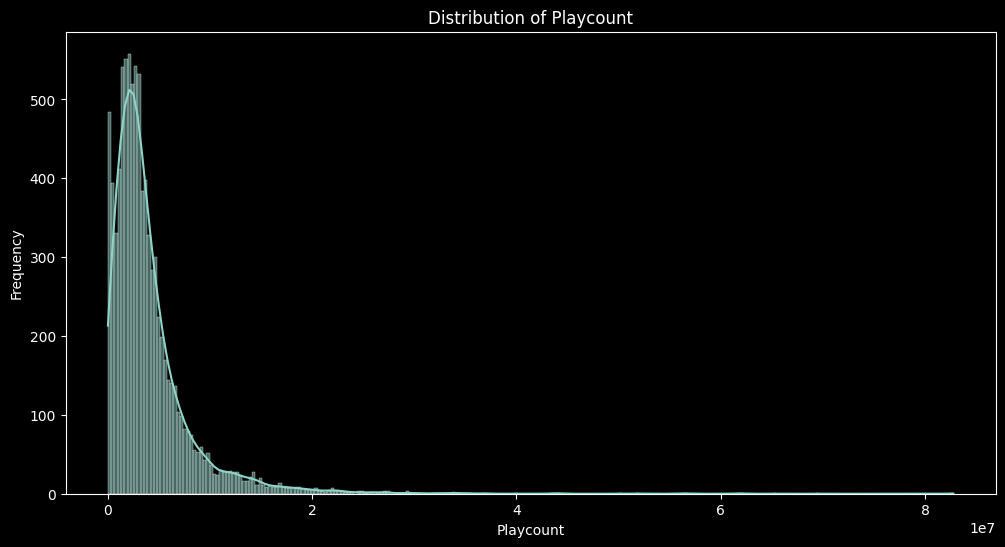

Playcount Statistics:
count    8.888000e+03
mean     4.105465e+06
std      4.407101e+06
min      3.240400e+04
25%      1.666427e+06
50%      2.984814e+06
75%      4.994725e+06
max      8.277397e+07
Name: playcount, dtype: float64

Number of outliers in playcount: 614
Sample of outliers:
                     name               artist   playcount
143       Come as You Are              Nirvana  25876357.0
1148         Teddy Picker       Arctic Monkeys  12841531.0
1066    Famous Last Words  My Chemical Romance  10069321.0
3790  Time Is Running Out                 Muse  13697615.0
174         Teenage Dream           Katy Perry  14936934.0


In [27]:
print("Analyzing Playcount:")
analyze_playcount(imputed_data)

In [28]:
def analyze_categorical_vs_playcount(df, top_n=20):
    # Artist vs Average Playcount
    artist_avg_playcount = df.groupby('artist')['playcount'].mean().sort_values(ascending=False)
    plt.figure(figsize=(12, 6))
    artist_avg_playcount.head(top_n).plot(kind='bar')
    plt.title(f'Top {top_n} Artists by Average Playcount')
    plt.xlabel('Artist')
    plt.ylabel('Average Playcount')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Tags vs Average Playcount
    def get_top_tags(tags_series, top_n=20):
        all_tags = [tag.strip() for tags in tags_series for tag in tags.split(',')]
        return pd.Series(all_tags).value_counts().head(top_n).index

    top_tags = get_top_tags(df['tags'], top_n)
    tag_avg_playcount = {tag: df[df['tags'].str.contains(tag)]['playcount'].mean() for tag in top_tags}
    tag_avg_playcount = pd.Series(tag_avg_playcount).sort_values(ascending=False)

    plt.figure(figsize=(12, 6))
    tag_avg_playcount.plot(kind='bar')
    plt.title(f'Average Playcount by Top {top_n} Tags')
    plt.xlabel('Tag')
    plt.ylabel('Average Playcount')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


Analyzing Categorical Variables vs Playcount:


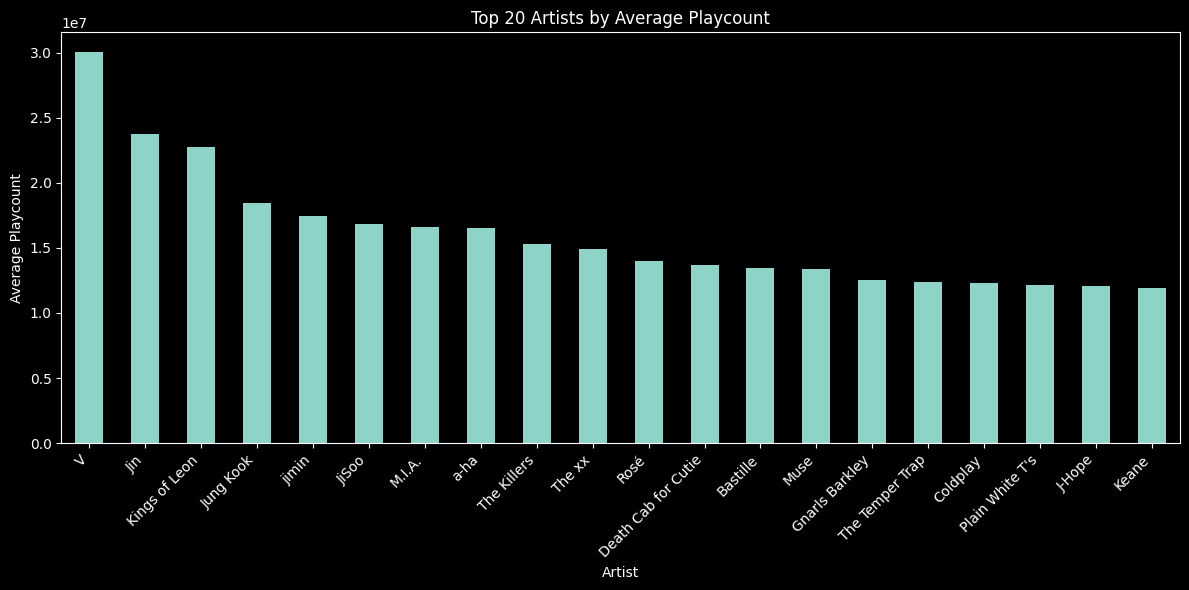

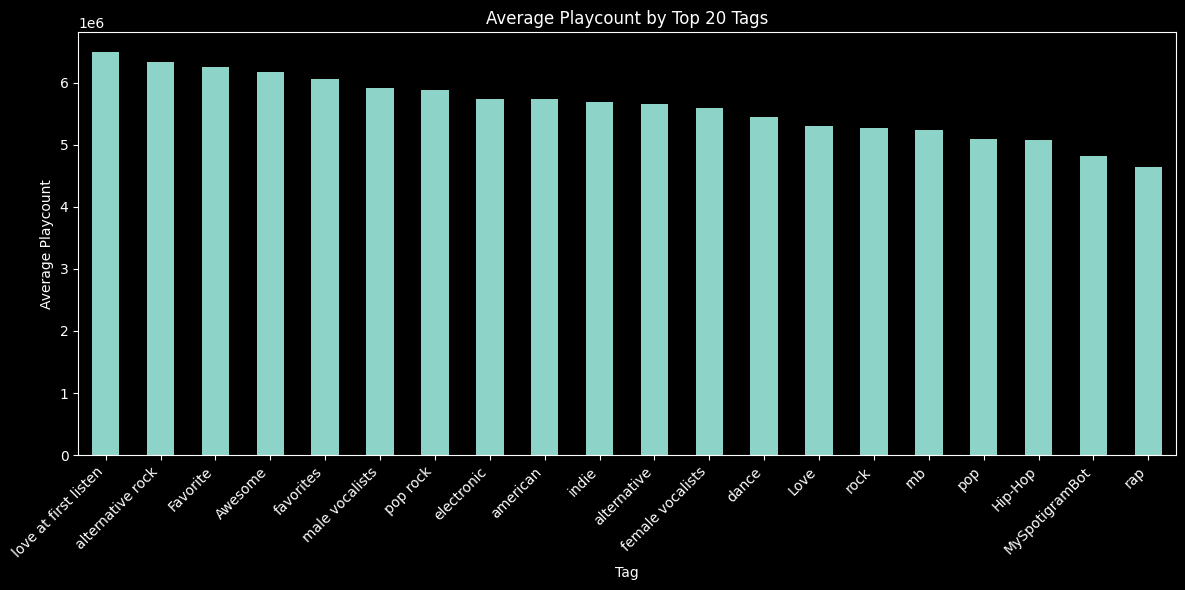

In [29]:
print("\nAnalyzing Categorical Variables vs Playcount:")
analyze_categorical_vs_playcount(imputed_data, top_n=20)

In [30]:
def analyze_co_occurrence(df, column, top_n=10):
    all_items = [set(items.split(', ')) for items in df[column]]
    co_occurrences = Counter()
    
    for items in all_items:
        co_occurrences.update(combinations(sorted(items), 2))
    
    co_occur = pd.Series(co_occurrences).sort_values(ascending=False).head(top_n)
    
    print(f"Top {top_n} co-occurring {column}:")
    print(co_occur)
    
    plt.figure(figsize=(12, 6))
    co_occur.plot(kind='bar')
    plt.title(f'Top {top_n} Co-occurring {column}')
    plt.xlabel(f'{column} Pairs')
    plt.ylabel('Co-occurrence Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


Analyzing Co-occurrences:
Top 10 co-occurring tags:
pop               rock        1890
alternative       rock        1671
                  pop         1593
Love              pop         1547
Awesome           pop         1401
favorites         rock        1397
alternative rock  rock        1394
alternative       indie       1352
Awesome           Favorite    1325
dance             pop         1318
dtype: int64


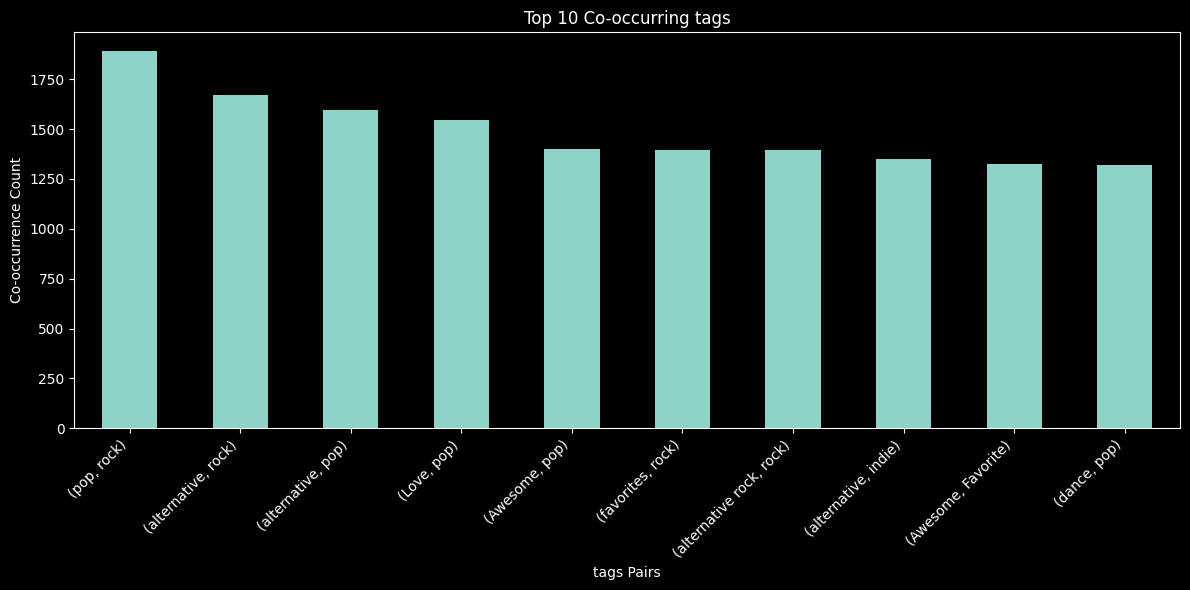

Top 10 co-occurring similar_tracks:
Awesome   Favorite     1488
          Love         1201
Favorite  Love         1035
Love      beautiful     993
Awesome   beautiful     832
Favorite  beautiful     732
Love      cool          687
Awesome   cool          642
Love      Mellow        638
Mellow    beautiful     595
dtype: int64


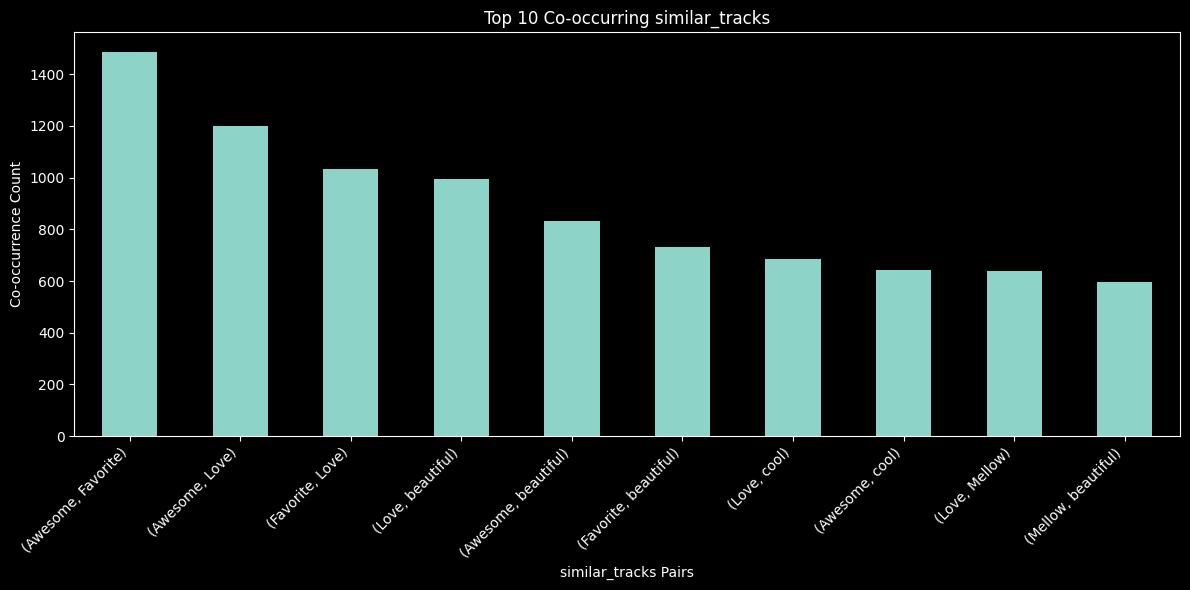

In [31]:
print("\nAnalyzing Co-occurrences:")
analyze_co_occurrence(imputed_data, 'tags')
analyze_co_occurrence(imputed_data, 'similar_tracks')

In [32]:
def analyze_binary_vs_playcount(df):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='has_tags', y='playcount', data=df)
    plt.title('Playcount Distribution by has_tags')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='has_similar_tracks', y='playcount', data=df)
    plt.title('Playcount Distribution by has_similar_tracks')
    plt.show()


Analyzing Binary Variables vs Playcount:


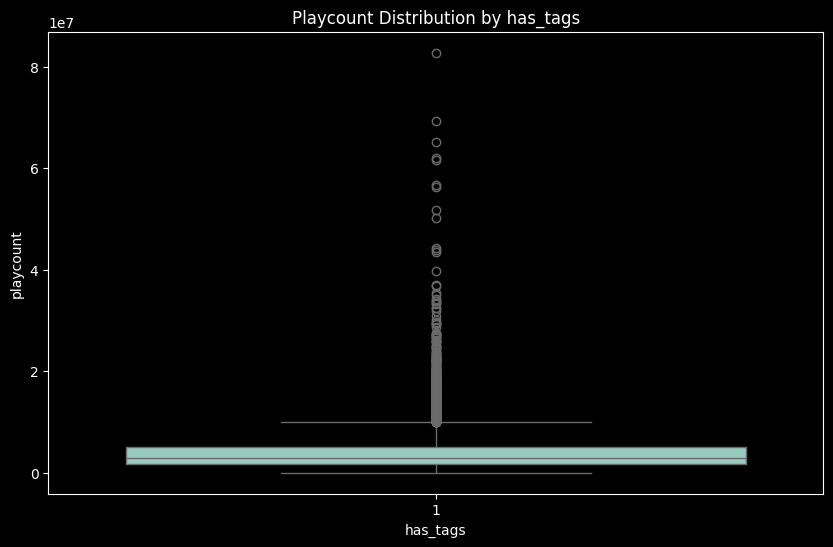

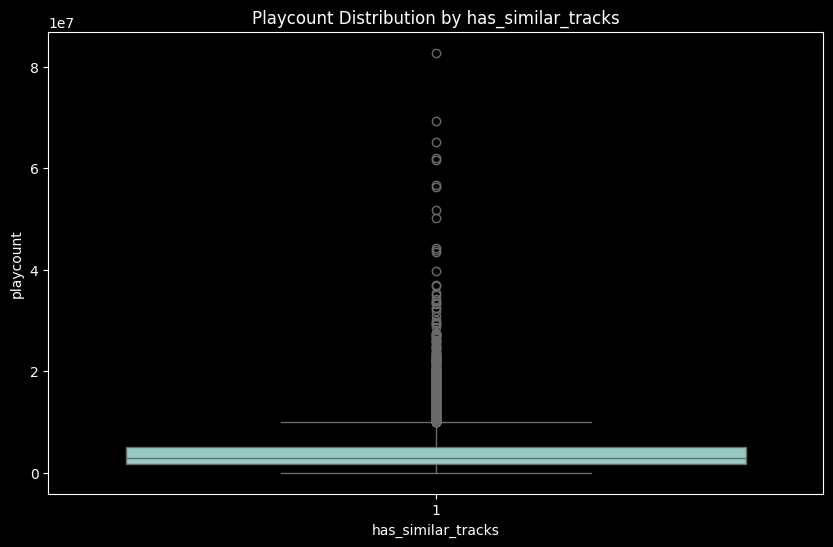

In [33]:
print("\nAnalyzing Binary Variables vs Playcount:")
analyze_binary_vs_playcount(imputed_data)

In [34]:
def analyze_tag_and_track_counts(df):
    analyzed_data = df.copy()
    analyzed_data.loc[:, 'num_tags'] = analyzed_data['tags'].apply(lambda x: len(x.split(', ')))
    analyzed_data.loc[:, 'num_similar_tracks'] = analyzed_data['similar_tracks'].apply(lambda x: len(x.split(', ')))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(analyzed_data['num_tags'], kde=True)
    plt.title('Distribution of Number of Tags')
    plt.subplot(1, 2, 2)
    sns.histplot(analyzed_data['num_similar_tracks'], kde=True)
    plt.title('Distribution of Number of Similar Tracks')
    plt.tight_layout()
    plt.show()


Analyzing Tag and Track Counts:


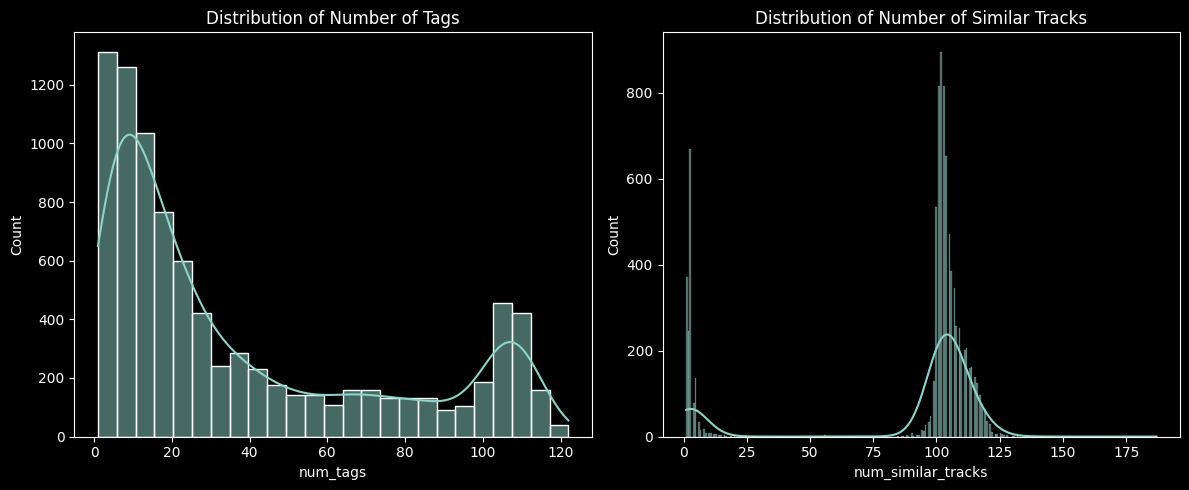

In [35]:
print("\nAnalyzing Tag and Track Counts:")
analyze_tag_and_track_counts(imputed_data)

In [36]:
imputed_data.head()

,name,artist,playcount,tags,similar_tracks,has_tags,has_similar_tracks
0,the boy is mine,Ariana Grande,11002687.0,"doo-wop, hip-hop soul, Ariana Grande, pop, gre...","scared of my guitar, Body, I luv it (feat. Pla...",1,1
1,I like the way you kiss me,Artemas,7725469.0,"fraudulent, pop, yeojinas, greedy, punk, new w...","Slow dancing in the dark, Something About You,...",1,1
2,Money Trees,Kendrick Lamar,21726085.0,"-1001819731063, kendrick lamar, 2013, pop, -10...","CATCH ME OUTSIDE, Still D.R.E., I Fall Apart, ...",1,1
3,Dark Red,Steve Lacy,24999120.0,"stevelacy mi rico, -1001819731063, summer, pop...","Forgive Me, For the First Time, HOTTIE, Pink +...",1,1
4,THE GREATEST,Billie Eilish,4874770.0,"singer-songwriter, waiting, alternative rock, ...","Found Heaven, Jaded, I luv it (feat. Playboi c...",1,1


# Feature Engineering

In [37]:
from sklearn.preprocessing import KBinsDiscretizer

In [38]:
def engineer_basic_features(df):
    # Create a copy of the dataframe to avoid SettingWithCopyWarning
    new_df = df.copy()
    
    # Log-transform the playcount
    new_df.loc[:, 'log_playcount'] = np.log1p(new_df['playcount'])
    
    # Create binned versions of playcount
    kbd = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
    new_df.loc[:, 'binned_playcount'] = kbd.fit_transform(new_df[['playcount']])
    
    # Create features for the number of tags and similar tracks
    new_df.loc[:, 'num_tags'] = new_df['tags'].apply(lambda x: len(x.split(', ')))
    new_df.loc[:, 'num_similar_tracks'] = new_df['similar_tracks'].apply(lambda x: len(x.split(', ')))
    
    return new_df

In [39]:
imputed_data_with_features = engineer_basic_features(imputed_data)

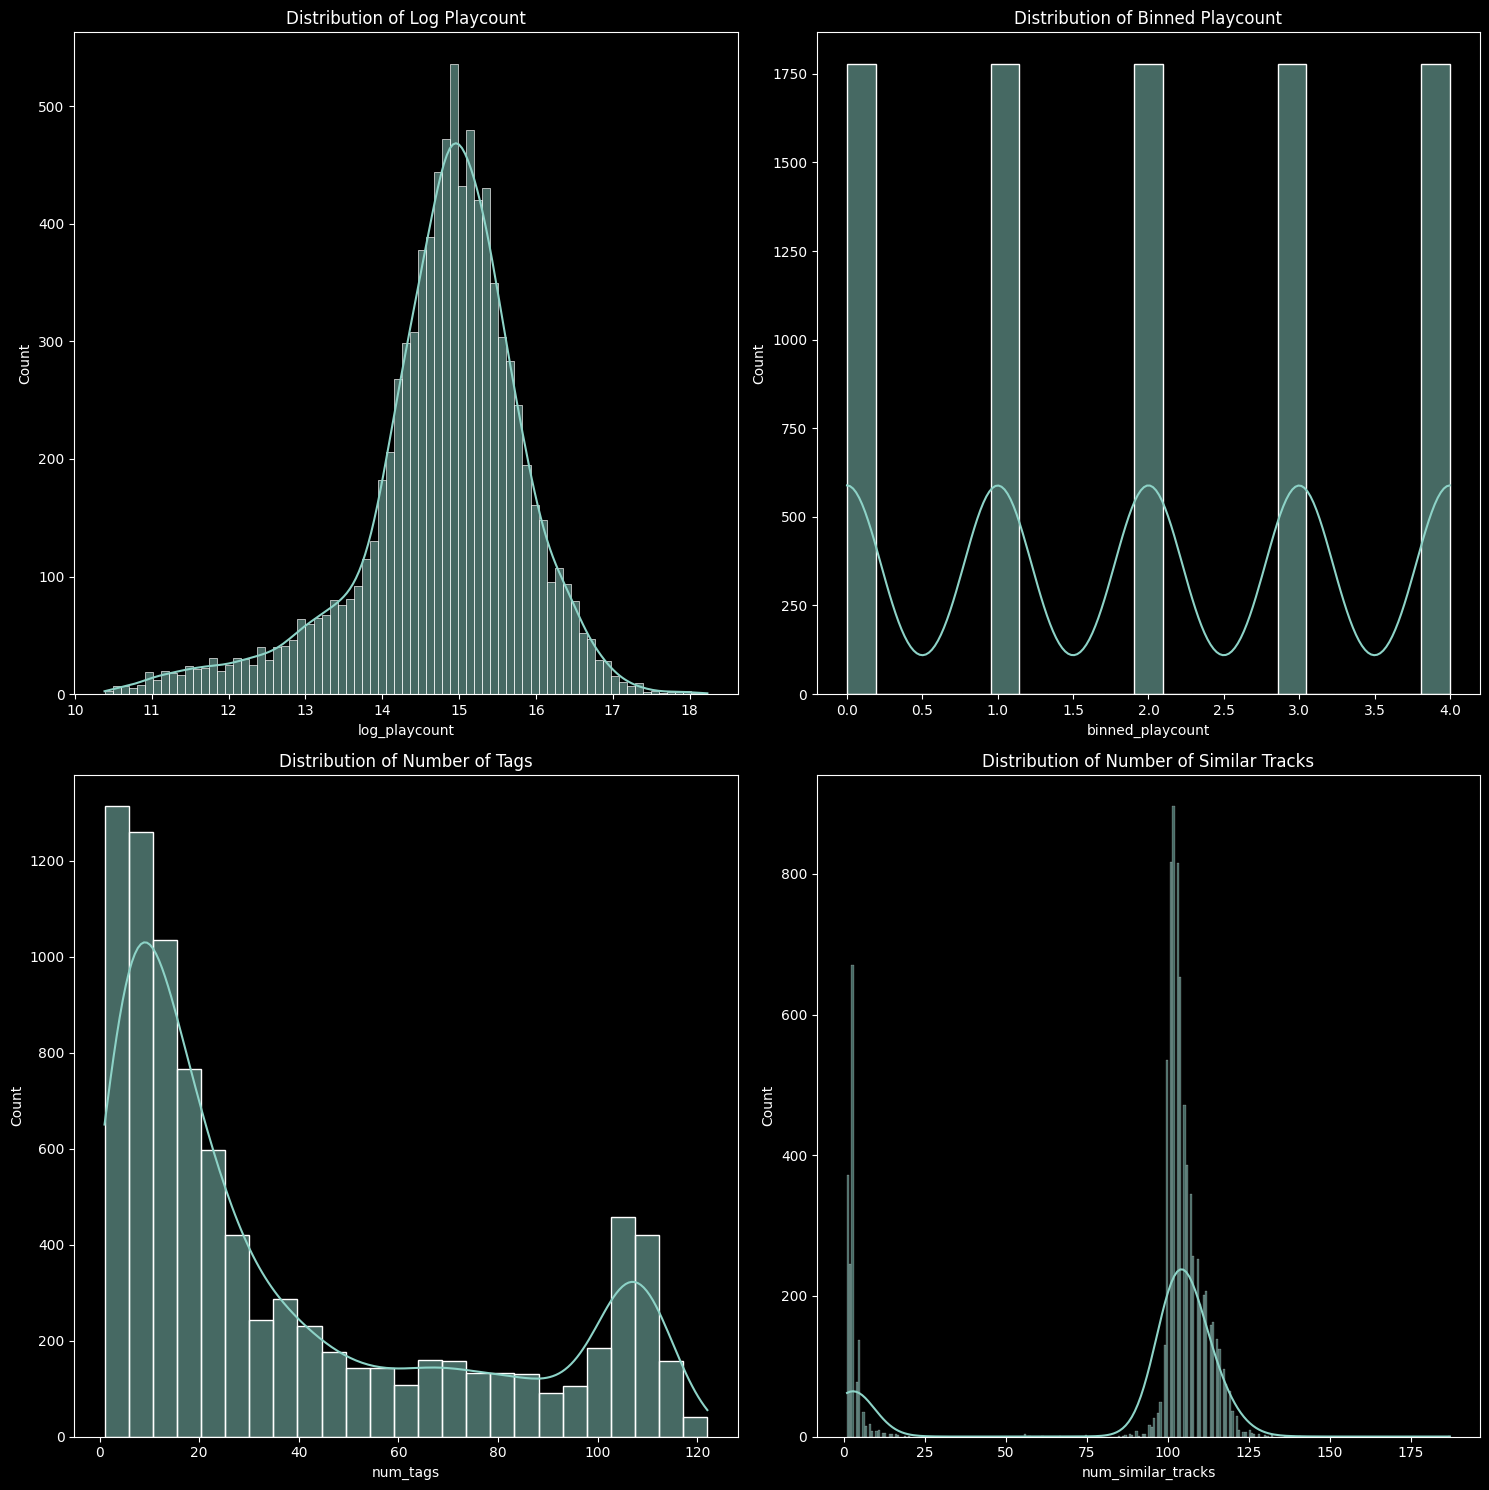

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_new_features(df):
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    
    sns.histplot(data=df, x='log_playcount', kde=True, ax=axes[0, 0])
    axes[0, 0].set_title('Distribution of Log Playcount')
    
    sns.histplot(data=df, x='binned_playcount', kde=True, ax=axes[0, 1])
    axes[0, 1].set_title('Distribution of Binned Playcount')
    
    sns.histplot(data=df, x='num_tags', kde=True, ax=axes[1, 0])
    axes[1, 0].set_title('Distribution of Number of Tags')
    
    sns.histplot(data=df, x='num_similar_tracks', kde=True, ax=axes[1, 1])
    axes[1, 1].set_title('Distribution of Number of Similar Tracks')
    
    plt.tight_layout()
    plt.show()

plot_new_features(imputed_data_with_features)

In [41]:
def engineer_additional_features(df):
    # Create a copy of the dataframe
    new_df = df.copy()
    
    # Binary feature for high tag count
    new_df['high_tag_count'] = (new_df['num_tags'] > 50).astype(int)
    
    # Bin number of tags
    new_df['tag_count_category'] = pd.cut(new_df['num_tags'], 
                                        bins=[0, 10, 50, np.inf], 
                                        labels=['low', 'medium', 'high'])
    
    # Binary feature for having similar tracks
    new_df['has_similar_tracks'] = (new_df['num_similar_tracks'] > 0).astype(int)
    
    # Bin number of similar tracks
    new_df['similar_tracks_category'] = pd.cut(new_df['num_similar_tracks'], 
                                            bins=[0, 50, 100, np.inf], 
                                            labels=['low', 'medium', 'high'])
    
    # Interaction features
    new_df['log_playcount_x_num_tags'] = new_df['log_playcount'] * new_df['num_tags']
    new_df['log_playcount_x_num_similar_tracks'] = new_df['log_playcount'] * new_df['num_similar_tracks']
    
    return new_df

In [42]:
# Apply additional feature engineering
imputed_data_with_more_features = engineer_additional_features(imputed_data_with_features)

imputed_data_with_more_features = imputed_data_with_more_features.drop(['has_tags', 'has_similar_tracks'], axis=1)

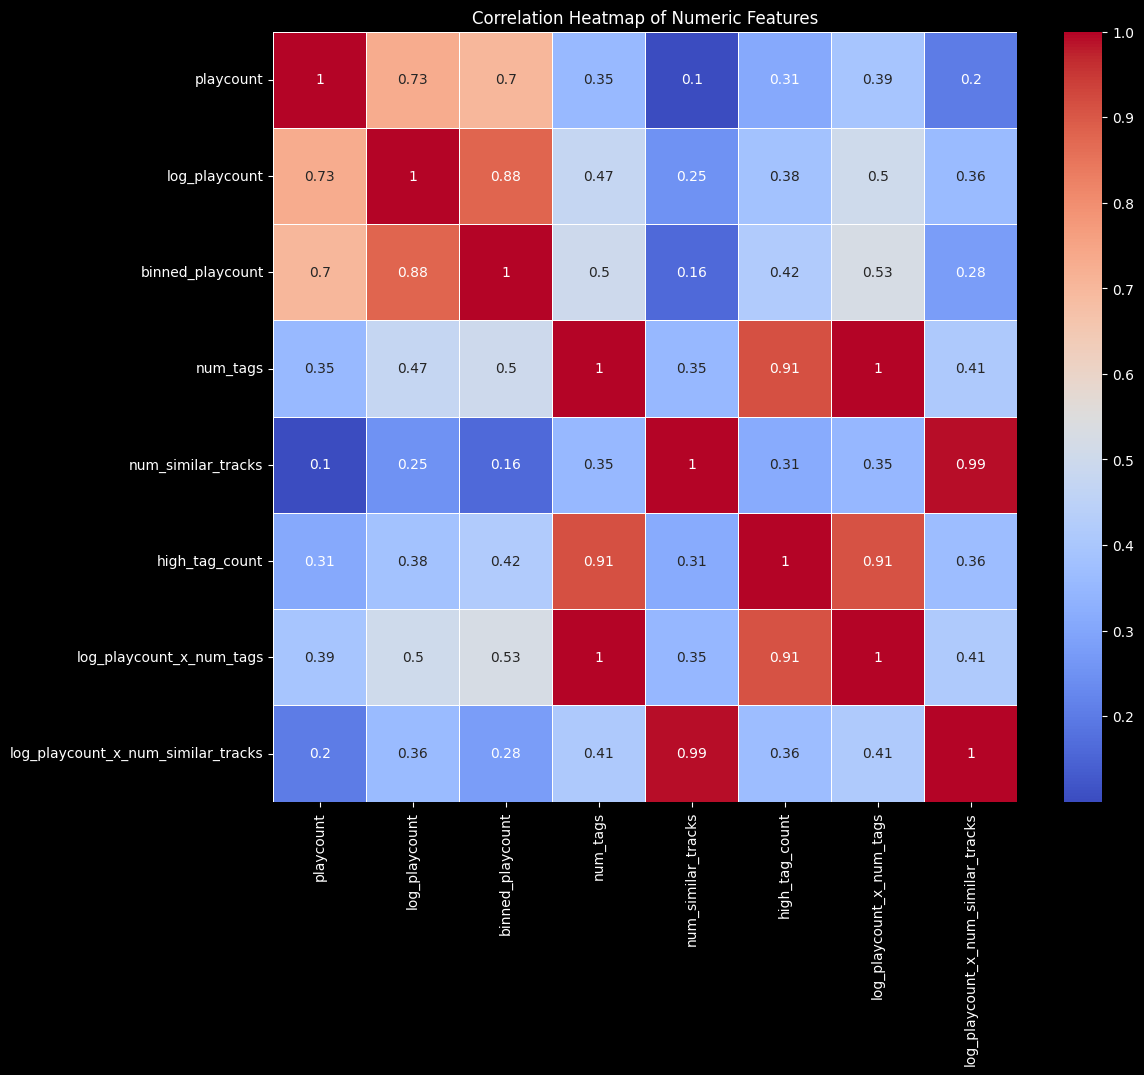

In [43]:
# Check correlations
correlation_matrix = imputed_data_with_more_features.select_dtypes(include=[np.number]).corr()

# Visualize correlations
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

In [62]:
def refine_features(df):
    # Create a copy of the dataframe
    new_df = df.copy()
    
    # Drop redundant features
    new_df = new_df.drop(['playcount', 'binned_playcount', 'high_tag_count', 
                        'log_playcount_x_num_tags', 'log_playcount_x_num_similar_tracks'], axis=1)
    
    # Create artist-based features
    new_df['artist_avg_playcount'] = new_df.groupby('artist')['log_playcount'].transform('mean')
    new_df['artist_track_count'] = new_df.groupby('artist')['name'].transform('count')
    
    # Create features for top N tags
    top_tags = new_df['tags'].str.split(', ', expand=True).stack().value_counts().nlargest(10).index
    for tag in top_tags:
        new_df[f'has_tag_{tag}'] = new_df['tags'].str.contains(tag).astype(int)
    
    return new_df

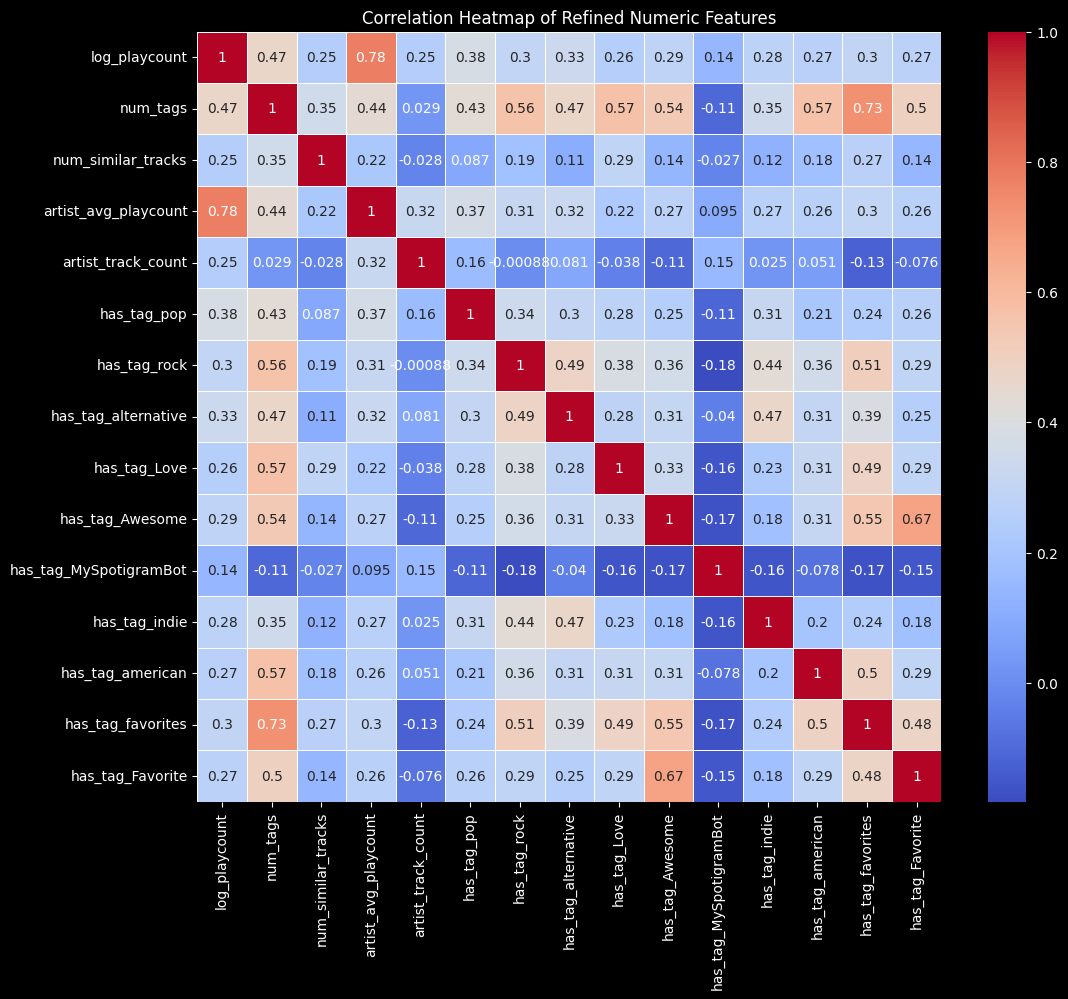

In [63]:
# Apply refined feature engineering
refined_data = refine_features(imputed_data_with_more_features)

# Check new correlations
new_correlation_matrix = refined_data.select_dtypes(include=[np.number]).corr()

# Visualize new correlations
plt.figure(figsize=(12, 10))
sns.heatmap(new_correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Refined Numeric Features')
plt.show()

In [64]:
def add_tag_popularity(df):
    # Split tags and create a dataframe
    tag_df = df['tags'].str.split(', ', expand=True).melt(value_name='tag').dropna()
    tag_df = tag_df.merge(df[['log_playcount']], left_index=True, right_index=True)
    
    # Calculate tag popularity
    tag_popularity = tag_df.groupby('tag')['log_playcount'].mean().sort_values(ascending=False)
    
    # Function to calculate average tag popularity
    def avg_tag_popularity(tags):
        if not tags:
            return 0
        tags_list = tags.split(', ')
        # Only consider tags that are in tag_popularity
        valid_tags = [tag for tag in tags_list if tag in tag_popularity.index]
        if not valid_tags:
            return 0
        return tag_popularity[valid_tags].mean()
    
    # Add tag popularity to main dataframe
    df['avg_tag_popularity'] = df['tags'].apply(avg_tag_popularity)
    
    return df

In [65]:
refined_data = add_tag_popularity(refined_data)

In [66]:
def add_similar_tracks_avg_playcount(df):
    # Create a dictionary of track name to log_playcount
    track_playcount = dict(zip(df['name'], df['log_playcount']))
    
    # Function to get average playcount of similar tracks
    def get_avg_playcount(similar_tracks):
        playcounts = [track_playcount.get(track.strip(), 0) for track in similar_tracks.split(', ')]
        return sum(playcounts) / len(playcounts) if playcounts else 0
    
    df['avg_similar_tracks_playcount'] = df['similar_tracks'].apply(get_avg_playcount)
    
    return df

In [67]:
refined_data = add_similar_tracks_avg_playcount(refined_data)

In [68]:
def add_interaction_features(df):
    df['artist_popularity_x_avg_tag_popularity'] = df['artist_avg_playcount'] * df['avg_tag_popularity']
    df['num_tags_x_avg_similar_tracks_playcount'] = df['num_tags'] * df['avg_similar_tracks_playcount']
    
    return df

In [69]:
refined_data_with_interaction_feat = add_interaction_features(refined_data)

In [70]:
def add_target_encoding(df):
    # Calculate mean log_playcount for each artist
    artist_means = df.groupby('artist')['log_playcount'].mean()
    
    # Calculate global mean
    global_mean = df['log_playcount'].mean()
    
    # Function to encode with smoothing
    def encode(artist):
        n = df[df['artist'] == artist].shape[0]
        return (n * artist_means.get(artist, global_mean) + global_mean) / (n + 1)
    
    # Apply encoding
    df['artist_target_encoded'] = df['artist'].apply(encode)
    
    return df

In [71]:
refined_data_stop1 = add_target_encoding(refined_data_with_interaction_feat)

In [72]:
non_numeric_columns = refined_data_stop1.select_dtypes(exclude=[np.number]).columns
print("Non-numeric columns:", non_numeric_columns.tolist())

Non-numeric columns: ['name', 'artist', 'tags', 'similar_tracks', 'tag_count_category', 'similar_tracks_category']


In [73]:
def refine_features_further(df):
    # Combine redundant features
    df['has_tag_favorites_combined'] = df[['has_tag_favorites', 'has_tag_Favorite']].max(axis=1)
    df = df.drop(['has_tag_favorites', 'has_tag_Favorite', 'has_tag_MySpotigramBot'], axis=1)
    
    # Create a composite tag popularity score
    tag_columns = [col for col in df.columns if col.startswith('has_tag_')]
    df['tag_popularity_score'] = df[tag_columns].mean(axis=1)
    
    # Create interaction term
    df['artist_avg_playcount_x_num_tags'] = df['artist_avg_playcount'] * df['num_tags']
    
    return df

In [74]:
# Apply further refinements
refined_data = refine_features_further(refined_data_stop1)
refined_data_stop1.head()

,name,artist,tags,similar_tracks,log_playcount,num_tags,num_similar_tracks,tag_count_category,similar_tracks_category,artist_avg_playcount,...,has_tag_indie,has_tag_american,has_tag_favorites,has_tag_Favorite,avg_tag_popularity,avg_similar_tracks_playcount,artist_popularity_x_avg_tag_popularity,num_tags_x_avg_similar_tracks_playcount,artist_target_encoded,has_tag_favorites_combined
0,the boy is mine,Ariana Grande,"doo-wop, hip-hop soul, Ariana Grande, pop, gre...","scared of my guitar, Body, I luv it (feat. Pla...",16.213650,37,105,medium,high,15.465819,...,0,0,0,0,13.797995,7.797327,213.397301,288.501085,15.456167,0
1,I like the way you kiss me,Artemas,"fraudulent, pop, yeojinas, greedy, punk, new w...","Slow dancing in the dark, Something About You,...",15.860033,28,104,medium,high,14.812143,...,0,0,0,0,14.613433,9.380350,216.456258,262.649810,14.804228,0
2,Money Trees,Kendrick Lamar,"-1001819731063, kendrick lamar, 2013, pop, -10...","CATCH ME OUTSIDE, Still D.R.E., I Fall Apart, ...",16.894024,54,106,high,high,15.324436,...,0,0,0,0,13.391765,8.954185,205.221244,483.525976,15.316067,0
3,Dark Red,Steve Lacy,"stevelacy mi rico, -1001819731063, summer, pop...","Forgive Me, For the First Time, HOTTIE, Pink +...",17.034351,32,105,medium,high,15.346290,...,1,0,0,0,14.236843,7.753169,218.482733,248.101424,15.314857,0
4,THE GREATEST,Billie Eilish,"singer-songwriter, waiting, alternative rock, ...","Found Heaven, Jaded, I luv it (feat. Playboi c...",15.399584,30,106,medium,high,15.595628,...,0,0,0,0,14.118712,8.083912,220.190176,242.517348,15.576671,0


In [75]:
rows_before = len(refined_data)
refined_data_clean = refined_data.dropna()
rows_after = len(refined_data_clean)

In [76]:
print(f"Size of df before {rows_before} vs after {rows_after}")

Size of df before 8888 vs after 8888


In [77]:


# Select features for modeling
features = [col for col in refined_data_clean.columns if col != 'log_playcount']
X = refined_data_clean[features]
y = refined_data_clean['log_playcount']

print("Columns with NaN values:")
print(X.columns[X.isna().any()].tolist())
print("\nNumber of NaN values in each column:")
print(X.isna().sum())

Columns with NaN values:
[]

Number of NaN values in each column:
name                                       0
artist                                     0
tags                                       0
similar_tracks                             0
num_tags                                   0
num_similar_tracks                         0
tag_count_category                         0
similar_tracks_category                    0
artist_avg_playcount                       0
artist_track_count                         0
has_tag_pop                                0
has_tag_rock                               0
has_tag_alternative                        0
has_tag_Love                               0
has_tag_Awesome                            0
has_tag_indie                              0
has_tag_american                           0
avg_tag_popularity                         0
avg_similar_tracks_playcount               0
artist_popularity_x_avg_tag_popularity     0
num_tags_x_avg_similar_tracks_play

In [78]:
def review_categorical_features(df):
    cat_cols = ['tag_count_category', 'similar_tracks_category']
    for col in cat_cols:
        print(f"\nValue counts for {col}:")
        print(df[col].value_counts())

review_categorical_features(refined_data_clean)


Value counts for tag_count_category:
medium    3781
low       2573
high      2534
Name: tag_count_category, dtype: int64

Value counts for similar_tracks_category:
high      6434
low       1619
medium     835
Name: similar_tracks_category, dtype: int64


In [79]:
def refine_feature_set(df):
    # Create a copy of the dataframe
    new_df = df.copy()
    
    # Drop redundant features
    new_df = new_df.drop(['artist_popularity_x_avg_tag_popularity', 'artist_avg_playcount_x_num_tags'], axis=1)

    return new_df

In [80]:
refined_data_new = refine_feature_set(refined_data_clean)

In [81]:
def analyze_vocabulary_sizes(df):
    text_features = ['name', 'artist', 'tags', 'similar_tracks']
    for feature in text_features:
        unique_terms = set()
        for text in df[feature]:
            unique_terms.update(text.split(','))
        print(f"{feature} unique terms: {len(unique_terms)}")

analyze_vocabulary_sizes(refined_data_new)

name unique terms: 8708
artist unique terms: 2322
tags unique terms: 42477
similar_tracks unique terms: 92926


In [82]:
# Identify and remove previously vectorized track name features
name_tfidf_columns = [col for col in refined_data_new.columns if col.startswith('name_tfidf_')]
refined_data_new = refined_data_new.drop(columns=name_tfidf_columns)

In [164]:

def save_data_artifact(df, base_path, filename):
    if df is not None:
            display(df.head())  # Print the first few rows of the DataFrame to verify

            # Ensure the directory exists
            output_dir = os.path.join(os.getcwd(), base_path)
            os.makedirs(output_dir, exist_ok=True)

            # Save DataFrame to the specified path
            output_path = os.path.join(output_dir, filename)
            df.to_csv(output_path, index=False)
            print(f"Data saved to {output_path}")
    else:
        print("Failed to fetch data, DataFrame is None")


,name,artist,tags,similar_tracks,log_playcount,num_tags,num_similar_tracks,tag_count_category,similar_tracks_category,artist_avg_playcount,...,has_tag_Love,has_tag_Awesome,has_tag_indie,has_tag_american,avg_tag_popularity,avg_similar_tracks_playcount,num_tags_x_avg_similar_tracks_playcount,artist_target_encoded,has_tag_favorites_combined,tag_popularity_score
0,the boy is mine,Ariana Grande,"doo-wop, hip-hop soul, Ariana Grande, pop, gre...","scared of my guitar, Body, I luv it (feat. Pla...",16.213650,37,105,medium,high,15.465819,...,0,0,0,0,13.797995,7.797327,288.501085,15.456167,0,0.125
1,I like the way you kiss me,Artemas,"fraudulent, pop, yeojinas, greedy, punk, new w...","Slow dancing in the dark, Something About You,...",15.860033,28,104,medium,high,14.812143,...,1,0,0,0,14.613433,9.380350,262.649810,14.804228,0,0.500
2,Money Trees,Kendrick Lamar,"-1001819731063, kendrick lamar, 2013, pop, -10...","CATCH ME OUTSIDE, Still D.R.E., I Fall Apart, ...",16.894024,54,106,high,high,15.324436,...,0,0,0,0,13.391765,8.954185,483.525976,15.316067,0,0.250
3,Dark Red,Steve Lacy,"stevelacy mi rico, -1001819731063, summer, pop...","Forgive Me, For the First Time, HOTTIE, Pink +...",17.034351,32,105,medium,high,15.346290,...,0,0,1,0,14.236843,7.753169,248.101424,15.314857,0,0.500
4,THE GREATEST,Billie Eilish,"singer-songwriter, waiting, alternative rock, ...","Found Heaven, Jaded, I luv it (feat. Playboi c...",15.399584,30,106,medium,high,15.595628,...,1,0,0,0,14.118712,8.083912,242.517348,15.576671,0,0.500


Data saved to /Users/johnphillip/spotify_music_recommendation/data/processed/feature_engineered_music_data.csv


In [83]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

def vectorize_all_text_features(df, max_features_dict=None):
    if max_features_dict is None:
        max_features_dict = {
            'artist': None,  # This will use all unique artists
            'tags': 300,
            'similar_tracks': None
        }
    
    # Check if 'name' has already been vectorized
    if 'name' not in max_features_dict and not any(col.startswith('name_tfidf_') for col in df.columns):
        max_features_dict['name'] = 8000
    
    text_features = list(max_features_dict.keys())
    vectorized_dfs = []
    vectorizers = {}

    for feature in text_features:
        if feature in ['name', 'artist']:
            # Treat each unique value as a document
            unique_values = df[feature].unique()
            text_data = pd.Series(unique_values)
        else:
            text_data = df[feature].fillna('')

        tfidf = TfidfVectorizer(max_features=max_features_dict[feature])
        tfidf_matrix = tfidf.fit_transform(text_data)
        
        feature_df = pd.DataFrame(
            tfidf_matrix.toarray(),
            columns=[f'{feature}_tfidf_{i}' for i in range(tfidf_matrix.shape[1])]
        )

        if feature in ['name', 'artist']:
            # Map the vectorized features back to the original dataframe
            feature_to_vector = dict(zip(unique_values, feature_df.values))
            vectorized_feature = df[feature].map(lambda x: feature_to_vector.get(x, np.zeros(max_features_dict[feature])))
            feature_df = pd.DataFrame(vectorized_feature.tolist(), 
                                    columns=feature_df.columns, 
                                    index=df.index)
        else:
            feature_df.index = df.index

        vectorized_dfs.append(feature_df)
        vectorizers[feature] = tfidf

    df_vectorized = pd.concat([df] + vectorized_dfs, axis=1)
    
    return df_vectorized, vectorizers

In [84]:
# Apply vectorization
max_features_dict = {
    'artist': None,
    'tags': 300,
    'similar_tracks': 500
}

df_vectorized, vectorizers = vectorize_all_text_features(refined_data_new, max_features_dict)

# Print the shape of the resulting dataframe to see the total number of features
print(f"Shape of vectorized dataframe: {df_vectorized.shape}")

# Print the number of features for each text attribute
for feature in ['name', 'artist', 'tags', 'similar_tracks']:
    print(f"Number of {feature} features: {len([col for col in df_vectorized.columns if col.startswith(f'{feature}_tfidf_')])}")

/var/folders/fn/1_rdw8wd0bx79n6v3zrg1t2m0000gn/T/ipykernel_31698/2165576880.py:39: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  vectorized_feature = df[feature].map(lambda x: feature_to_vector.get(x, np.zeros(max_features_dict[feature])))


Shape of vectorized dataframe: (8888, 10822)
Number of name features: 6857
Number of artist features: 3141
Number of tags features: 300
Number of similar_tracks features: 500


In [85]:
df_vectorized.describe()

,log_playcount,num_tags,num_similar_tracks,artist_avg_playcount,artist_track_count,has_tag_pop,has_tag_rock,has_tag_alternative,has_tag_Love,has_tag_Awesome,...,name_tfidf_6847,name_tfidf_6848,name_tfidf_6849,name_tfidf_6850,name_tfidf_6851,name_tfidf_6852,name_tfidf_6853,name_tfidf_6854,name_tfidf_6855,name_tfidf_6856
count,8888.000000,8888.00000,8888.000000,8888.000000,8888.000000,8888.000000,8888.000000,8888.000000,8888.000000,8888.000000,...,8888.000000,8888.000000,8888.000000,8888.000000,8888.000000,8888.000000,8888.000000,8888.000000,8888.000000,8888.000000
mean,14.780484,37.45027,86.841247,14.780484,22.147840,0.620162,0.384788,0.345972,0.335621,0.230648,...,0.000113,0.000113,0.000113,0.000063,0.000113,0.000067,0.000058,0.000058,0.000081,0.000080
std,1.063355,36.41627,39.902107,0.825212,32.919448,0.485374,0.486573,0.475711,0.472234,0.421271,...,0.010607,0.010607,0.010607,0.005983,0.010607,0.006275,0.005461,0.005461,0.007665,0.007500
min,10.386068,1.00000,1.000000,10.587846,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,14.326193,9.00000,100.000000,14.409724,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,14.909048,21.00000,103.000000,14.917154,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,15.423893,61.00000,107.000000,15.369969,26.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,18.231624,122.00000,187.000000,16.940178,179.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.564028,1.000000,0.591588,0.514852,0.514852,0.722588,0.707107


In [86]:
print("Columns with NaN values:")
print(df_vectorized.columns[df_vectorized.isna().any()].tolist())
print("\nNumber of NaN values in each column:")
print(df_vectorized.isna().sum())

Columns with NaN values:
[]

Number of NaN values in each column:
name               0
artist             0
tags               0
similar_tracks     0
log_playcount      0
                  ..
name_tfidf_6852    0
name_tfidf_6853    0
name_tfidf_6854    0
name_tfidf_6855    0
name_tfidf_6856    0
Length: 10822, dtype: int64


In [87]:
df_vectorized.head(1)

,name,artist,tags,similar_tracks,log_playcount,num_tags,num_similar_tracks,tag_count_category,similar_tracks_category,artist_avg_playcount,...,name_tfidf_6847,name_tfidf_6848,name_tfidf_6849,name_tfidf_6850,name_tfidf_6851,name_tfidf_6852,name_tfidf_6853,name_tfidf_6854,name_tfidf_6855,name_tfidf_6856
0,the boy is mine,Ariana Grande,"doo-wop, hip-hop soul, Ariana Grande, pop, gre...","scared of my guitar, Body, I luv it (feat. Pla...",16.21365,37,105,medium,high,15.465819,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [88]:
# Prepare final feature set
def get_final_features(df):
    original_text_cols = ['name', 'artist', 'tags', 'similar_tracks']
    feature_cols = [col for col in df.columns if col not in original_text_cols]
    print("Final feature set:")
    print(feature_cols)
    return df[feature_cols]

final_features = get_final_features(df_vectorized)

Final feature set:
['log_playcount', 'num_tags', 'num_similar_tracks', 'tag_count_category', 'similar_tracks_category', 'artist_avg_playcount', 'artist_track_count', 'has_tag_pop', 'has_tag_rock', 'has_tag_alternative', 'has_tag_Love', 'has_tag_Awesome', 'has_tag_indie', 'has_tag_american', 'avg_tag_popularity', 'avg_similar_tracks_playcount', 'num_tags_x_avg_similar_tracks_playcount', 'artist_target_encoded', 'has_tag_favorites_combined', 'tag_popularity_score', 'artist_tfidf_0', 'artist_tfidf_1', 'artist_tfidf_2', 'artist_tfidf_3', 'artist_tfidf_4', 'artist_tfidf_5', 'artist_tfidf_6', 'artist_tfidf_7', 'artist_tfidf_8', 'artist_tfidf_9', 'artist_tfidf_10', 'artist_tfidf_11', 'artist_tfidf_12', 'artist_tfidf_13', 'artist_tfidf_14', 'artist_tfidf_15', 'artist_tfidf_16', 'artist_tfidf_17', 'artist_tfidf_18', 'artist_tfidf_19', 'artist_tfidf_20', 'artist_tfidf_21', 'artist_tfidf_22', 'artist_tfidf_23', 'artist_tfidf_24', 'artist_tfidf_25', 'artist_tfidf_26', 'artist_tfidf_27', 'artist_tf

In [102]:
final_features.shape

(8888, 10818)

In [118]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
import sklearn

def create_preprocessing_pipeline(df, n_components=100):
    # Identify different types of columns
    numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = df.select_dtypes(include=['object']).columns.tolist()
    tfidf_features = [col for col in df.columns if '_tfidf_' in col]
    
    # Create the preprocessing steps
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    tfidf_transformer = Pipeline(steps=[
        ('svd', TruncatedSVD(n_components=min(n_components, len(tfidf_features)), algorithm='randomized', n_iter=5, random_state=42))
    ])
    
    # Combine all the preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features),
            ('tfidf', tfidf_transformer, tfidf_features)
        ])
    
    # Create the full pipeline
    full_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('replace_inf', FunctionTransformer(lambda X: np.nan_to_num(X, nan=0, posinf=0, neginf=0)))
    ])
    
    return full_pipeline

def get_feature_names(input_features, n_components):
    feature_names = []
    numeric_features = input_features.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = input_features.select_dtypes(include=['object']).columns.tolist()
    tfidf_features = [col for col in input_features.columns if '_tfidf_' in col]
    
    feature_names.extend(numeric_features)
    
    for cat_feature in categorical_features:
        unique_values = input_features[cat_feature].unique()
        feature_names.extend([f"{cat_feature}_{value}" for value in unique_values])
    
    feature_names.extend([f'svd_tfidf_{i}' for i in range(min(n_components, len(tfidf_features)))])
    
    return feature_names

In [119]:
# Assume final_features is your DataFrame with pre-vectorized text features
# Use the pipeline
n_components = 4000  # Set this to the same value as in create_preprocessing_pipeline
pipeline = create_preprocessing_pipeline(final_features, n_components)

# Fit and transform the data
X_processed = pipeline.fit_transform(final_features)

# Get feature names
feature_names = get_feature_names(final_features, n_components)

# Ensure the number of feature names matches the number of columns in X_processed
if X_processed.shape[1] != len(feature_names):
    print(f"Warning: Number of features ({X_processed.shape[1]}) doesn't match number of feature names ({len(feature_names)})")
    feature_names = [f'feature_{i}' for i in range(X_processed.shape[1])]

# Create a new dataframe with processed features
df_processed = pd.DataFrame(X_processed, columns=feature_names, index=final_features.index)

print("Shape after preprocessing:", df_processed.shape)
print("\nSample of processed features:")
print(df_processed.head())

# Calculate and print the total variance explained for TFIDF features
tfidf_transformer = pipeline.named_steps['preprocessor'].named_transformers_['tfidf']
tfidf_features = [col for col in final_features.columns if '_tfidf_' in col]

if tfidf_features:
    # Get SVD object
    svd = tfidf_transformer.named_steps['svd']
    
    # Calculate explained variance ratio
    explained_variance_ratio = svd.explained_variance_ratio_
    total_variance_explained = sum(explained_variance_ratio)
    print(f"\nTotal variance explained by SVD components for TFIDF features: {total_variance_explained:.2%}")
else:
    print("\nNo TFIDF features found in the dataset.")

Shape after preprocessing: (8888, 14816)

Sample of processed features:
   log_playcount  num_tags  num_similar_tracks  artist_avg_playcount  \
0       1.347854 -0.012365            0.455108              0.830543   
1       1.015287 -0.259521            0.430045              0.038368   
2       1.987727  0.454485            0.480171              0.659203   
3       2.119700 -0.149674            0.455108              0.685688   
4       0.582246 -0.204598            0.480171              0.987854   

   artist_track_count  has_tag_pop  has_tag_rock  has_tag_alternative  \
0            1.453695     0.782612     -0.790859            -0.727315   
1           -0.581690     0.782612      1.264449             1.374921   
2            1.271422     0.782612      1.264449            -0.727315   
3           -0.156386     0.782612      1.264449             1.374921   
4            0.603087     0.782612      1.264449             1.374921   

   has_tag_Love  has_tag_Awesome  ...  svd_tfidf_3990  s

In [160]:
df_processed.head()

,log_playcount,num_tags,num_similar_tracks,artist_avg_playcount,artist_track_count,has_tag_pop,has_tag_rock,has_tag_alternative,has_tag_Love,has_tag_Awesome,...,svd_tfidf_3990,svd_tfidf_3991,svd_tfidf_3992,svd_tfidf_3993,svd_tfidf_3994,svd_tfidf_3995,svd_tfidf_3996,svd_tfidf_3997,svd_tfidf_3998,svd_tfidf_3999
0,1.347854,-0.012365,0.455108,0.830543,1.453695,0.782612,-0.790859,-0.727315,-0.710750,-0.547536,...,-0.004023,0.005049,0.001648,0.001722,0.000107,0.004275,-0.000100,-0.004501,0.003888,-0.001635
1,1.015287,-0.259521,0.430045,0.038368,-0.581690,0.782612,1.264449,1.374921,1.406965,-0.547536,...,0.001407,0.004061,0.002856,-0.009987,-0.006165,-0.000796,0.004344,0.010161,0.003736,0.002155
2,1.987727,0.454485,0.480171,0.659203,1.271422,0.782612,1.264449,-0.727315,-0.710750,-0.547536,...,-0.008765,-0.005989,-0.003946,-0.006738,-0.009372,-0.000168,-0.000101,0.004549,0.001900,-0.005874
3,2.119700,-0.149674,0.455108,0.685688,-0.156386,0.782612,1.264449,1.374921,-0.710750,-0.547536,...,0.002094,-0.002431,-0.001414,-0.003716,0.000146,-0.001024,0.007589,-0.001226,0.000598,0.001489
4,0.582246,-0.204598,0.480171,0.987854,0.603087,0.782612,1.264449,1.374921,1.406965,-0.547536,...,-0.000172,0.000440,0.003783,-0.001980,-0.002083,-0.005679,0.000446,0.006692,-0.001067,-0.002499


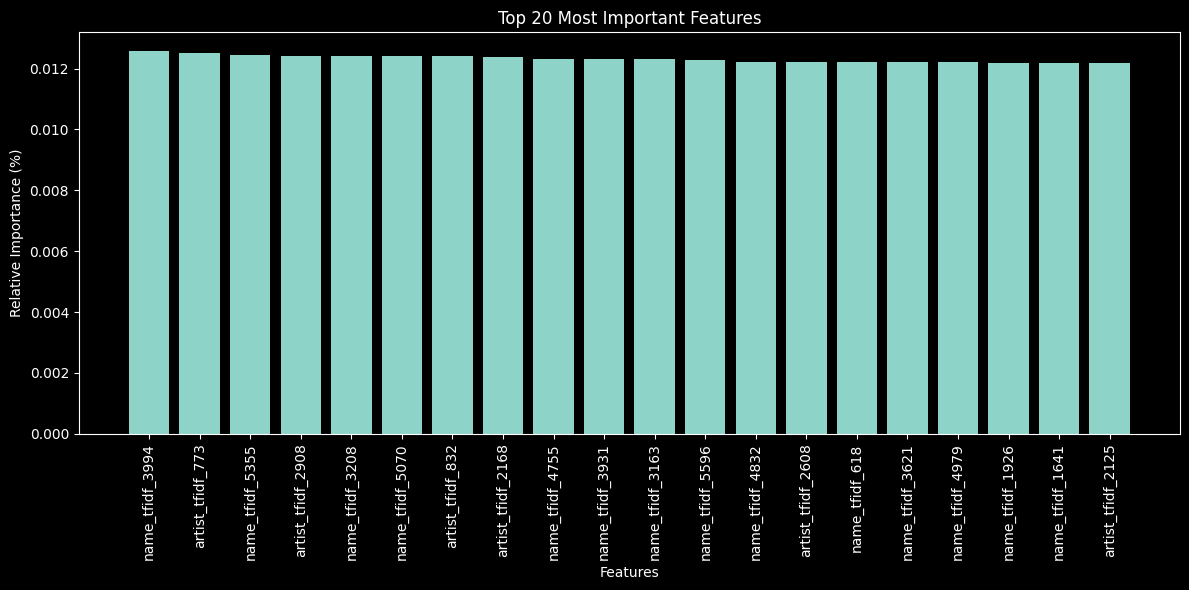

Top 20 most important features:
                feature  importance
7953    name_tfidf_3994    0.012564
791    artist_tfidf_773    0.012504
9314    name_tfidf_5355    0.012460
2926  artist_tfidf_2908    0.012425
7167    name_tfidf_3208    0.012421
9029    name_tfidf_5070    0.012412
850    artist_tfidf_832    0.012407
2186  artist_tfidf_2168    0.012392
8714    name_tfidf_4755    0.012320
7890    name_tfidf_3931    0.012317
7122    name_tfidf_3163    0.012313
9555    name_tfidf_5596    0.012272
8791    name_tfidf_4832    0.012233
2626  artist_tfidf_2608    0.012232
4577     name_tfidf_618    0.012230
7580    name_tfidf_3621    0.012213
8938    name_tfidf_4979    0.012204
5885    name_tfidf_1926    0.012199
5600    name_tfidf_1641    0.012198
2143  artist_tfidf_2125    0.012195


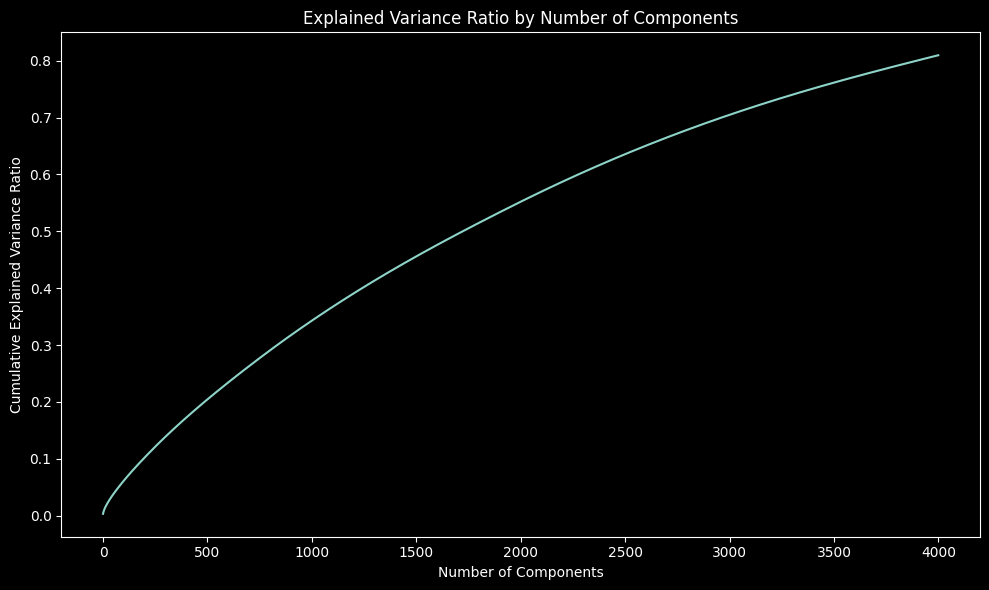

Shape after Truncated SVD: (8888, 4000)
Cumulative explained variance ratio: 0.8095


In [120]:
from sklearn.decomposition import TruncatedSVD
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def analyze_feature_importance_and_reduce_dimensions(df, n_components=4000):
    # Perform Truncated SVD
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    svd_result = svd.fit_transform(df)
    
    # Analyze feature importance
    feature_importance = np.sum(np.abs(svd.components_), axis=0)
    feature_importance = 100.0 * (feature_importance / feature_importance.sum())
    
    # Create a DataFrame of feature importances
    feature_importance_df = pd.DataFrame({
        'feature': df.columns,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    # Plot feature importance
    plt.figure(figsize=(12, 6))
    plt.bar(range(20), feature_importance_df['importance'][:20])
    plt.xticks(range(20), feature_importance_df['feature'][:20], rotation=90)
    plt.xlabel('Features')
    plt.ylabel('Relative Importance (%)')
    plt.title('Top 20 Most Important Features')
    plt.tight_layout()
    plt.show()
    
    # Print top 20 most important features
    print("Top 20 most important features:")
    print(feature_importance_df.head(20))
    
    # Plot cumulative explained variance ratio
    plt.figure(figsize=(10, 6))
    plt.plot(np.cumsum(svd.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('Explained Variance Ratio by Number of Components')
    plt.tight_layout()
    plt.show()
    
    # Create DataFrame with reduced dimensions
    columns = [f'SVD_{i+1}' for i in range(svd_result.shape[1])]
    df_svd = pd.DataFrame(svd_result, columns=columns, index=df.index)
    
    print(f"Shape after Truncated SVD: {df_svd.shape}")
    print(f"Cumulative explained variance ratio: {np.sum(svd.explained_variance_ratio_):.4f}")
    
    return df_svd, svd, feature_importance_df

# Apply the function to our preprocessed data
df_svd, svd, feature_importance = analyze_feature_importance_and_reduce_dimensions(df_processed)

# Model Building

In [122]:
import tensorflow as tf
import keras
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

try:
    import scikeras
    print(f"Scikeras version: {scikeras.__version__}")
except ImportError:
    print("Scikeras is not installed")

TensorFlow version: 2.15.1
Keras version: 2.15.0
Scikeras version: 0.12.0


In [155]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers, models, optimizers, backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from scipy.stats import uniform, randint
import joblib
import json

def prepare_data(df_svd, original_df):
    X = df_svd.values
    mlb = MultiLabelBinarizer()
    y = mlb.fit_transform(original_df['similar_tracks'].str.split(','))
    track_names = original_df['name'].values
    
    X_train, X_test, y_train, y_test, names_train, names_test = train_test_split(
        X, y, track_names, test_size=0.2, random_state=42
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test, names_train, names_test, scaler, mlb

def build_model(input_dim, output_dim, hidden_layers=2, neurons=64, learning_rate=0.001):
    model = models.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    
    for _ in range(hidden_layers):
        model.add(layers.Dense(neurons, activation='relu'))
    
    model.add(layers.Dense(output_dim, activation='sigmoid', name='embedding'))
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['binary_accuracy', cosine_similarity]
    )
    return model

def cosine_similarity(y_true, y_pred):
    y_true = K.l2_normalize(y_true, axis=-1)
    y_pred = K.l2_normalize(y_pred, axis=-1)
    return -K.sum(y_true * y_pred, axis=-1)


class FilteredCallback(tf.keras.callbacks.ModelCheckpoint):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Create a logger
        self.logger = logging.getLogger('tensorflow')
        # Set the logger level to ERROR to suppress INFO messages
        self.logger.setLevel(logging.ERROR)

    def on_epoch_end(self, epoch, logs=None):
        # Temporarily change the logger level
        original_level = self.logger.level
        self.logger.setLevel(logging.ERROR)
        
        # Call the parent method
        super().on_epoch_end(epoch, logs)
        
        # Restore the original logger level
        self.logger.setLevel(original_level)

def train_model(model, X_train, y_train, X_val, y_val, epochs=20, batch_size=32): # change epochs back to 100 after testing
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        FilteredCallback(
            filepath='best_model',
            save_best_only=True,
            monitor='val_loss',
            mode='min',
            save_format='tf'
        )
    ]
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )
    return history


def hyperparameter_tuning(X_train, y_train, X_val, y_val, input_dim, output_dim):
    param_distributions = {
        'hidden_layers': randint(1, 4),
        'neurons': randint(32, 129),
        'learning_rate': uniform(0.0001, 0.01),
        'batch_size': randint(16, 65)
    }

    best_val_loss = float('inf')
    best_params = None
    best_model = None

    n_iter = 1  # Number of parameter settings that are sampled 12

    for _ in range(n_iter):
        params = {
            'hidden_layers': param_distributions['hidden_layers'].rvs(),
            'neurons': param_distributions['neurons'].rvs(),
            'learning_rate': param_distributions['learning_rate'].rvs(),
            'batch_size': param_distributions['batch_size'].rvs()
        }
        
        model = build_model(
            input_dim=input_dim, 
            output_dim=output_dim,
            hidden_layers=params['hidden_layers'],
            neurons=params['neurons'],
            learning_rate=params['learning_rate']
        )
        
        history = train_model(
            model, X_train, y_train, X_val, y_val,
            epochs=20,  # Reduced epochs for faster tuning
            batch_size=params['batch_size']
        )
        
        val_loss = min(history.history['val_loss'])
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_params = params
            best_model = model

        print(f"Params: {params}, Val Loss: {val_loss}")

    print("Best parameters found: ", best_params)

    # Save the best parameters
    with open('best_params.json', 'w') as f:
        json.dump(best_params, f)
        
    return best_params, best_model


def find_similar_tracks(model, track_features, all_features, track_names, n=5):
    track_embedding = model.predict(track_features.reshape(1, -1))
    all_embeddings = model.predict(all_features)
    
    similarities = np.dot(track_embedding, all_embeddings.T)
    top_indices = similarities.argsort()[0][-n:][::-1]
    
    return [(track_names[i], similarities[0][i]) for i in top_indices]

In [156]:
# Utility functions

def save_model_artifacts(model, scaler, mlb, feature_names, base_path):
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    model_dir = os.path.join(base_path, f"model_{timestamp}")
    os.makedirs(model_dir, exist_ok=True)

    # Save model in the new .keras format
    model_path = os.path.join(model_dir, "saved_model")
    model.save(model_path, save_format='tf')
    print(f"Model saved to {model_path}")

    joblib.dump(scaler, os.path.join(model_dir, "scaler.joblib"))
    joblib.dump(mlb, os.path.join(model_dir, "mlb.joblib"))
    
    with open(os.path.join(model_dir, "model_summary.txt"), 'w') as f:
        model.summary(print_fn=lambda x: f.write(x + '\n'))
    
    with open(os.path.join(model_dir, "feature_names.txt"), 'w') as f:
        for feature in feature_names:
            f.write(f"{feature}\n")
    
    print(f"Model and artifacts saved to {model_dir}")
    return model_dir

def load_model_artifacts(model_dir):
    full_model_dir = os.path.join(model_dir, 'saved_model')
    
    print(f"Attempting to load artifacts from: {full_model_dir}")

    # Load model
    model_path = full_model_dir
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model directory not found in {model_path}")
    model = tf.keras.models.load_model(model_path, custom_objects={'cosine_similarity': cosine_similarity})
    print(f"Model loaded from {model_path}")

    # Load scaler
    scaler_path = os.path.join(full_model_dir, "..", "scaler.joblib")
    if not os.path.exists(scaler_path):
        raise FileNotFoundError(f"Scaler file not found: {scaler_path}")
    scaler = joblib.load(scaler_path)
    print(f"Scaler loaded from {scaler_path}")

    # Load MultiLabelBinarizer
    mlb_path = os.path.join(full_model_dir, "..", "mlb.joblib")
    if not os.path.exists(mlb_path):
        raise FileNotFoundError(f"MLB file not found: {mlb_path}")
    mlb = joblib.load(mlb_path)
    print(f"MultiLabelBinarizer loaded from {mlb_path}")

    # Load feature names
    feature_names_path = os.path.join(full_model_dir, "..", "feature_names.txt")
    if not os.path.exists(feature_names_path):
        raise FileNotFoundError(f"Feature names file not found: {feature_names_path}")
    with open(feature_names_path, 'r') as f:
        feature_names = [line.strip() for line in f]
    print(f"Feature names loaded from {feature_names_path}")

    return model, scaler, mlb, feature_names


In [157]:
def visualize_training_history(history):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    
    plt.subplot(1, 3, 2)
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    
    plt.subplot(1, 3, 3)
    plt.plot(history.history['cosine_similarity'])
    plt.plot(history.history['val_cosine_similarity'])
    plt.title('Cosine Similarity')
    plt.ylabel('Similarity')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    
    plt.tight_layout()
    plt.show()

Epoch 1/20
155/155 [==============================] - 56s 335ms/step - loss: 0.0401 - binary_accuracy: 0.9958 - cosine_similarity: -0.0705 - val_loss: 0.0115 - val_binary_accuracy: 0.9991 - val_cosine_similarity: -0.0803
Epoch 2/20
155/155 [==============================] - 77s 499ms/step - loss: 0.0107 - binary_accuracy: 0.9991 - cosine_similarity: -0.0891 - val_loss: 0.0102 - val_binary_accuracy: 0.9991 - val_cosine_similarity: -0.0897
Epoch 3/20
155/155 [==============================] - 64s 411ms/step - loss: 0.0097 - binary_accuracy: 0.9991 - cosine_similarity: -0.1084 - val_loss: 0.0085 - val_binary_accuracy: 0.9991 - val_cosine_similarity: -0.1007
Epoch 4/20
155/155 [==============================] - 52s 335ms/step - loss: 0.0075 - binary_accuracy: 0.9991 - cosine_similarity: -0.1427 - val_loss: 0.0077 - val_binary_accuracy: 0.9991 - val_cosine_similarity: -0.1289
Epoch 5/20
155/155 [==============================] - 49s 318ms/step - loss: 0.0060 - binary_accuracy: 0.9991 - cosi

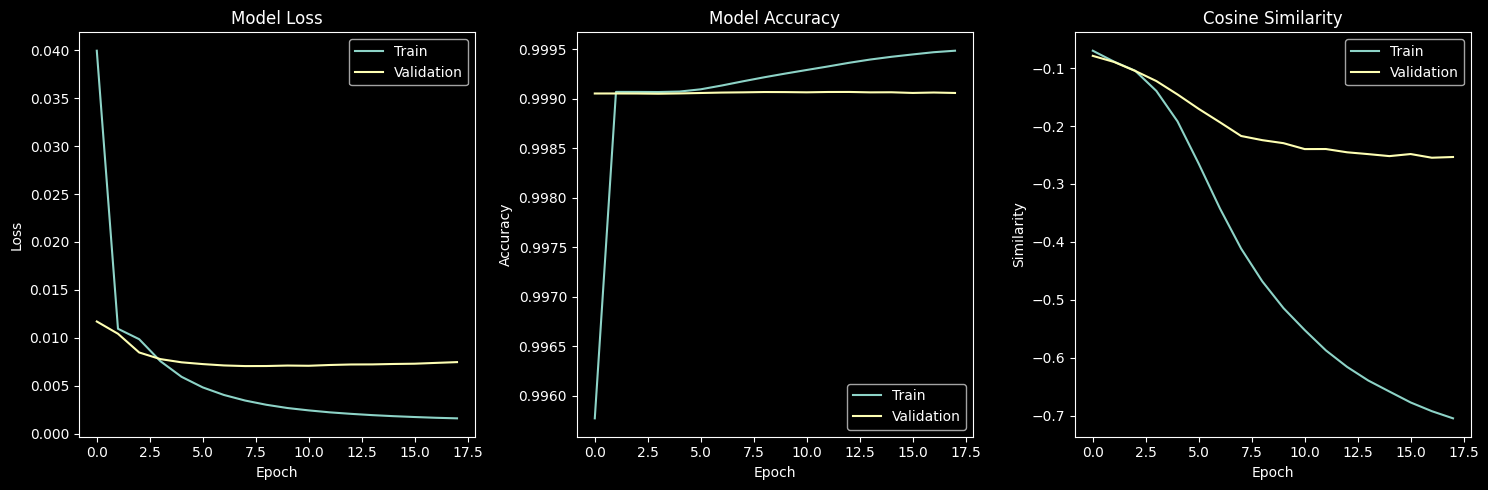

Model saved to /Users/johnphillip/spotify_music_recommendation/notebooks/model_20240814_010006/saved_model
Model and artifacts saved to /Users/johnphillip/spotify_music_recommendation/notebooks/model_20240814_010006
Attempting to load artifacts from: /Users/johnphillip/spotify_music_recommendation/notebooks/model_20240814_010006/saved_model
Model loaded from /Users/johnphillip/spotify_music_recommendation/notebooks/model_20240814_010006/saved_model
Scaler loaded from /Users/johnphillip/spotify_music_recommendation/notebooks/model_20240814_010006/saved_model/../scaler.joblib
MultiLabelBinarizer loaded from /Users/johnphillip/spotify_music_recommendation/notebooks/model_20240814_010006/saved_model/../mlb.joblib
Feature names loaded from /Users/johnphillip/spotify_music_recommendation/notebooks/model_20240814_010006/saved_model/../feature_names.txt
All artifacts loaded successfully.
56/56 [==============================] - 1s 20ms/step
Similar tracks to 'People':
People: 81.03915405273438

In [158]:
if __name__ == "__main__":
    # Prepare data
    X_train, X_test, y_train, y_test, names_train, names_test, scaler, mlb = prepare_data(df_svd, df_vectorized)

    # Hyperparameter tuning
    best_params, best_model = hyperparameter_tuning(X_train, y_train, X_test, y_test, 
                                                    input_dim=df_svd.shape[1], 
                                                    output_dim=len(mlb.classes_))

    # Load the best parameters
    with open('best_params.json', 'r') as f:
        best_params = json.load(f)

    model_params = {
        'hidden_layers': best_params['hidden_layers'],
        'neurons': best_params['neurons'],
        'learning_rate': best_params['learning_rate']
    }
    batch_size = best_params['batch_size']

    # Train the final model with best parameters
    final_model = build_model(input_dim=df_svd.shape[1], output_dim=len(mlb.classes_), **model_params)
    history = train_model(final_model, X_train, y_train, X_test, y_test, batch_size=batch_size)

    # Visualize training history
    visualize_training_history(history)

    # Save model and artifacts
    base_path='/Users/johnphillip/spotify_music_recommendation/notebooks'
    model_dir = save_model_artifacts(final_model, scaler, mlb, df_svd.columns, base_path)
    
    try:
        loaded_model, loaded_scaler, loaded_mlb, loaded_feature_names = load_model_artifacts(model_dir)
        print("All artifacts loaded successfully.")

        # Find similar tracks example
        example_track_index = 0
        similar_tracks = find_similar_tracks(loaded_model, X_test[example_track_index], X_test, names_test)
        print(f"Similar tracks to '{names_test[example_track_index]}':")
        for name, similarity in similar_tracks:
            print(f"{name}: {similarity}")

    except FileNotFoundError as e:
        print(f"Error loading artifacts: {e}")

In [147]:
# 

# Evaluate on test data
test_loss, test_accuracy, test_cosine_similarity = loaded_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Cosine Similarity: {test_cosine_similarity}")

56/56 [==============================] - 3s 48ms/step - loss: 0.0078 - binary_accuracy: 0.9990 - cosine_similarity: -0.2429
Test Loss: 0.007753954268991947
Test Accuracy: 0.9990465044975281
Test Cosine Similarity: -0.24294358491897583
